In [1]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8 # assert sum to 1.0
    positive=0
    # 0 - suma  
    # 1 - no suma
    # 10 suma
    # 11 no suma
    # 100 suma
    # 101 no suma
    # suma la probabilidad de todos los bitstrings pares,
    # en otras palabras, la probabilidad de que el qubit 0 sea 0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(3,20):
        assert counter[i]==0
        
    return counter

In [2]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

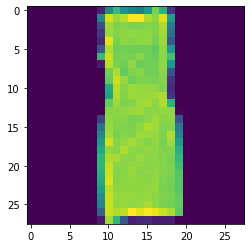

In [3]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
plt.imshow(images[1100])

In [4]:
#your submission

# Functions 'encode' and 'decode' are dummy.
def encode(image):
    q = qiskit.QuantumRegister(3)
    circuit = qiskit.QuantumCircuit(q)
    if image[0][0]==0:
        circuit.rx(np.pi,0)
    return circuit


def run_part2(image):

    #loade the quantum classifier circuit
    classifier=qiskit.QuantumCircuit.from_qasm_file('quantum_classifier.qasm')
    
    #encode image into circuit
    circuit=encode(image)
    
    #append with classifier circuit
    nq1 = circuit.width()
    nq2 = classifier.width()
    nq = max(nq1, nq2)
    qc = qiskit.QuantumCircuit(nq)
    qc.append(circuit.to_instruction(), list(range(nq1)))
    qc.append(classifier.to_instruction(), list(range(nq2)))
    
    #simulate circuit
    histogram=simulate(qc)
        
    #convert histogram to category
    label=histogram_to_category(histogram)
        
    return circuit,label
#score

In [5]:
#how we grade your submission

score=0
gatecount=0
n=len(dataset)

for data in dataset:
    #run part 2
    circuit,label=run_part2(data['image'])
    
    #count the gate used in the circuit for score calculation
    gatecount+=count_gates(circuit)[2]
    
    #check label
    if label==data['category']:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))

0.0


In [6]:
from qiskit import QuantumCircuit
from sklearn.decomposition import PCA

#your submission

# Functions 'encode' and 'decode' are dummy.
def encode_amplitude(images, image_index, n_qubits, debug=False):
    N_images = len(images)
    # We have 28x28 images as input
    # - we can do amplitude encoding of a normalized amplitude vector that has size of 2 ** n (full power of two)
    # 28 x 28 = 784 doesn't fit into a full power of two, so we use PCA to reduce the dimensionality to fit it 
    # into n_qubits (parametrized)
    
    
    # [apply PCA]
    # Create an instance of PCA
    pca = PCA(n_components=2**n_qubits)

    # Fit PCA on your 784-dimensional data
    data = images.reshape(N_images, 28 * 28)
    pca.fit(data)

    # Apply dimensionality reduction on your data
    data_pca = pca.transform(data)

    image = images[image_index]
    
    if debug:
    
        print("Raw Image data")
        print(data[image_index][:5])
    
    image_pca = data_pca[image_index]
    
    min_ = image_pca.min()
    
    if debug:
        print("Image PCA")
        print(image_pca[:5])

    
    image_pca = image_pca - min_
    
    if debug:
        print("Image PCA min_ removed")
        print(image_pca[:5])
    
    # [normalize]
    def normalize(row):
        #We calculate the squareroot of the sum of the square values of the row
        normalization_factor = np.sqrt(np.sum(row**2)) 
        if normalization_factor == 0.:
            #If the sum is zero we return a 0
            return 0.0
        #Else we divide each value between the sum value above
        row = row / normalization_factor
        return row, normalization_factor
    
    image_pca_normalized, normalization_factor = normalize(image_pca)
    
    if debug:
        print(image.shape)

        print(image_pca_normalized.shape)

        print(np.sum(image_pca_normalized**2))
    
    desired_state = image_pca_normalized
    
    #print(np.round(desired_state, 3))
    if debug:
        print("PCA normalized")
        print(np.round(image_pca_normalized, 5)[:5])

        print("Squared PCA")
        print(np.round(desired_state ** 2, 5)[:5])
    
    ##########
    # Amplitude Encoding
    qc = QuantumCircuit(n_qubits)
    qc.initialize(desired_state)
    qc_decomposed = qc.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose()

    ##########
    
    decoder_params = dict(
        pca=pca,
        min_=min_,
        normalization_factor=normalization_factor,
        n_qubits=n_qubits,
        image=image
    )
    
    return qc_decomposed, decoder_params

def run_part2(images, image_index, n_qubits):

    #loade the quantum classifier circuit
    classifier=qiskit.QuantumCircuit.from_qasm_file('quantum_classifier.qasm')
    
    #encode image into circuit
    circuit, _ = encode_amplitude(images, image_index, n_qubits)
    
    #append with classifier circuit
    nq1 = circuit.width()
    nq2 = classifier.width()
    nq = max(nq1, nq2)
    qc = qiskit.QuantumCircuit(nq)
    qc.append(circuit.to_instruction(), list(range(nq1)))
    qc.append(classifier.to_instruction(), list(range(nq2)))
    
    #simulate circuit
    histogram=simulate(qc)
        
    #convert histogram to category
    label=histogram_to_category(histogram)
        
    return circuit,label
#score

In [7]:
run_part2(images, 0, 8)

(<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fb54d38d550>,
 0.5323555582257801)

In [36]:
#how we grade your submission

score=0
gatecount=0
n=len(dataset)

for data in dataset:
    #run part 2
    circuit,label=run_part2(data['image'])
    
    #count the gate used in the circuit for score calculation
    gatecount+=count_gates(circuit)[2]
    
    #check label
    if label==data['category']:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))

TypeError: run_part2() missing 2 required positional arguments: 'image_index' and 'n_qubits'

In [38]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(1)
#qc.x(0)

a = qc.qasm(filename="quantum_classifier.qasm")

In [39]:
!ls

 data				       part1_example_qiskit.ipynb
 data1.json			       part1.py
 data2.json			       part2_example_cirq.ipynb
 examples.ipynb			       part2_example_qiskit-Copy1.ipynb
 examples_qiskit.ipynb		       part2_example_qiskit.ipynb
'MIT iQuHACK remote challenge .docx'   part2.pickle
 MIT_iQuHACK_remote_challenge.pdf      part2.qasm
 mock_data			       __pycache__
 mock_data_creator.ipynb	       quantum_classifier.qasm
 part1_example_cirq.ipynb	       README.md
 part1_example_qiskit-Copy1.ipynb


In [ ]:
# versioned classifer

In [122]:
classifier=qiskit.QuantumCircuit.from_qasm_file('quantum_classifier.qasm')

In [123]:
classifier.draw()

q:

In [129]:
labels

array([ True,  True,  True, ..., False, False, False])

In [ ]:
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
import tqdm

from scipy.optimize import minimize 


def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

#Function to identify a function cost
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Function cost
'''

def objective_function(params, images, labels, shots=1024, mini_batch=5, n_qubits=8):

    running_loss = 0

    images, labels = shuffle(images, labels, random_state=42)
    
    
    y_pred = []

    #For each item of the trainig set
    for i in tqdm.tqdm(range(mini_batch)):

        circuit, _ = encode_amplitud(images, i, n_qubits) #Create a inicial circuit
        vqc = ansatz(n_qubits)

        vqc = vqc.assign_parameters(params)

        #Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
        circuit_full = QuantumCircuit(n_qubits)
    
        qubits = list(range(n_qubits))
        
        circuit_full.append(circuit.to_instruction(), qubits)
        circuit_full.append(vqc.to_instruction(), qubits)

        #Combine the initial circuit, the quantum variatinal circuit and the swap test
        #For the initial circuit and QVC we start at the qubit size_reduce + 1
        #For the swap test we start at the qubit 0

        #Execute the circuit in the qasm_simulator
        histogram = simulate(circuit_full)

        pred_label = histogram_to_category(histogram)
        
        #print(histogram)
        print("Pred label")
        print(pred_label)
        
        y_pred.append(pred_label)
        
    y_true = labels[:mini_batch]
    

    loss = log_loss(y_true, y_pred)
    
    print(y_true, y_pred)
    print("Loss")
    print(loss)
    

    return loss

n_qubits = 8
shots = 1024
mini_batch = 5

vqc = ansatz(n_qubits)
initial_point = algorithm_globals.random.random(vqc.num_parameters)

for i in range(1):
    #Minimization of the objective_fucntion by a COBYLA method
    minimum = minimize(objective_function, initial_point, args=(images, labels, shots, mini_batch, n_qubits), method='COBYLA', tol=1e-6)
    params = minimum.x #Get the solution array
    #Show the cost of the solution array
    print("Cost: ", objective_function(params))
    print(params)

 20%|██        | 1/5 [00:09<00:38,  9.51s/it]

Pred label
0.5886651262609048


 40%|████      | 2/5 [00:29<00:46, 15.66s/it]

Pred label
0.635555073783909


 60%|██████    | 3/5 [00:50<00:35, 17.92s/it]

Pred label
0.6394353896795691


 80%|████████  | 4/5 [01:28<00:26, 26.20s/it]

Pred label
0.5571776351730213


100%|██████████| 5/5 [01:40<00:00, 20.11s/it]


Pred label
0.6313328175555944
[False  True False False False] [0.5886651262609048, 0.635555073783909, 0.6394353896795691, 0.5571776351730213, 0.6313328175555944]
Loss
0.8348271641207405


 20%|██        | 1/5 [00:10<00:40, 10.09s/it]

Pred label
0.5887672655465805


 40%|████      | 2/5 [00:24<00:37, 12.34s/it]

Pred label
0.5887795315504828


 60%|██████    | 3/5 [00:52<00:38, 19.49s/it]

Pred label
0.5946188604607769


 80%|████████  | 4/5 [01:25<00:25, 25.06s/it]

Pred label
0.5478308104464287


100%|██████████| 5/5 [01:58<00:00, 23.79s/it]


Pred label
0.5954196131409886
[False  True False False False] [0.5887672655465805, 0.5887795315504828, 0.5946188604607769, 0.5478308104464287, 0.5954196131409886]
Loss
0.8039661384001928


 20%|██        | 1/5 [00:10<00:41, 10.46s/it]

Pred label
0.6042148860124525


 40%|████      | 2/5 [00:17<00:24,  8.26s/it]

Pred label
0.5909436173541671


 60%|██████    | 3/5 [00:52<00:41, 20.53s/it]

Pred label
0.5872112853515093


 80%|████████  | 4/5 [01:11<00:19, 19.88s/it]

Pred label
0.581567395202677


100%|██████████| 5/5 [01:19<00:00, 15.83s/it]


Pred label
0.5882434543551341
[False  True False False False] [0.6042148860124525, 0.5909436173541671, 0.5872112853515093, 0.581567395202677, 0.5882434543551341]
Loss
0.8192600766547915


 20%|██        | 1/5 [00:23<01:35, 23.84s/it]

Pred label
0.6482366557230557


 40%|████      | 2/5 [01:02<01:37, 32.62s/it]

Pred label
0.629216034457888


 60%|██████    | 3/5 [01:19<00:51, 25.67s/it]

Pred label
0.6364463671356472


 80%|████████  | 4/5 [01:38<00:22, 22.75s/it]

Pred label
0.5952576435570955


100%|██████████| 5/5 [01:50<00:00, 22.01s/it]


Pred label
0.632391172474394
[False  True False False False] [0.6482366557230557, 0.629216034457888, 0.6364463671356472, 0.5952576435570955, 0.632391172474394]
Loss
0.8850292328798368


 20%|██        | 1/5 [00:06<00:27,  6.85s/it]

Pred label
0.5560127547288942


 40%|████      | 2/5 [00:22<00:35, 11.79s/it]

Pred label
0.5301498216093532


 60%|██████    | 3/5 [00:29<00:19,  9.99s/it]

Pred label
0.5375805143537935


 80%|████████  | 4/5 [00:39<00:09,  9.71s/it]

Pred label
0.506783527318943


100%|██████████| 5/5 [01:01<00:00, 12.32s/it]


Pred label
0.541118651861013
[False  True False False False] [0.5560127547288942, 0.5301498216093532, 0.5375805143537935, 0.506783527318943, 0.541118651861013]
Loss
0.7407217215964954


 20%|██        | 1/5 [00:14<00:56, 14.02s/it]

Pred label
0.5768871930688416


 40%|████      | 2/5 [00:20<00:28,  9.54s/it]

Pred label
0.5497010069723379


 60%|██████    | 3/5 [00:57<00:44, 22.18s/it]

Pred label
0.5697864242327038


 80%|████████  | 4/5 [01:11<00:18, 18.71s/it]

Pred label
0.5322058577855764


100%|██████████| 5/5 [01:43<00:00, 20.73s/it]


Pred label
0.5644241939997484
[False  True False False False] [0.5768871930688416, 0.5497010069723379, 0.5697864242327038, 0.5322058577855764, 0.5644241939997484]
Loss
0.7785568217225514


 20%|██        | 1/5 [00:07<00:31,  7.85s/it]

Pred label
0.5772392112104014


 40%|████      | 2/5 [00:23<00:38, 12.70s/it]

Pred label
0.5537397226449562


 60%|██████    | 3/5 [00:52<00:39, 19.78s/it]

Pred label
0.5668504855390445


 80%|████████  | 4/5 [01:00<00:15, 15.13s/it]

Pred label
0.533056444679258


100%|██████████| 5/5 [01:38<00:00, 19.61s/it]


Pred label
0.5653006066248942
[False  True False False False] [0.5772392112104014, 0.5537397226449562, 0.5668504855390445, 0.533056444679258, 0.5653006066248942]
Loss
0.7766658063282734


 20%|██        | 1/5 [00:42<02:49, 42.27s/it]

Pred label
0.46263282315096216


 40%|████      | 2/5 [00:55<01:15, 25.11s/it]

Pred label
0.4547075091520982


 60%|██████    | 3/5 [01:23<00:53, 26.60s/it]

Pred label
0.45840960165281147


 80%|████████  | 4/5 [01:30<00:18, 18.77s/it]

Pred label
0.44299854801015875


100%|██████████| 5/5 [02:07<00:00, 25.55s/it]


Pred label
0.4588012765777399
[False  True False False False] [0.46263282315096216, 0.4547075091520982, 0.45840960165281147, 0.44299854801015875, 0.4588012765777399]
Loss
0.6443152051419245


 20%|██        | 1/5 [00:28<01:52, 28.10s/it]

Pred label
0.4451348060818319


 40%|████      | 2/5 [00:37<00:50, 16.86s/it]

Pred label
0.43285858454688086


 60%|██████    | 3/5 [01:16<00:54, 27.06s/it]

Pred label
0.4379326714344286


 80%|████████  | 4/5 [01:36<00:24, 24.48s/it]

Pred label
0.4289803397148101


100%|██████████| 5/5 [02:18<00:00, 27.76s/it]


Pred label
0.4371584767496989
[False  True False False False] [0.4451348060818319, 0.43285858454688086, 0.4379326714344286, 0.4289803397148101, 0.4371584767496989]
Loss
0.6275193474653809


 20%|██        | 1/5 [00:32<02:10, 32.68s/it]

Pred label
0.5597488893554801


 40%|████      | 2/5 [01:07<01:42, 34.23s/it]

Pred label
0.5398738773269588


 60%|██████    | 3/5 [01:40<01:06, 33.40s/it]

Pred label
0.5408618872182283


 80%|████████  | 4/5 [02:01<00:28, 28.42s/it]

Pred label
0.571415618234901


100%|██████████| 5/5 [02:08<00:00, 25.79s/it]


Pred label
0.5552053951139723
[False  True False False False] [0.5597488893554801, 0.5398738773269588, 0.5408618872182283, 0.571415618234901, 0.5552053951139723]
Loss
0.7745288506165932


 20%|██        | 1/5 [00:06<00:24,  6.21s/it]

Pred label
0.3865351769054153


 40%|████      | 2/5 [00:44<01:15, 25.03s/it]

Pred label
0.3993995727392796


 60%|██████    | 3/5 [00:57<00:38, 19.40s/it]

Pred label
0.40966690819490065


 80%|████████  | 4/5 [01:10<00:17, 17.01s/it]

Pred label
0.38241319650500133


100%|██████████| 5/5 [01:18<00:00, 15.73s/it]


Pred label
0.4065279130003209
[False  True False False False] [0.3865351769054153, 0.3993995727392796, 0.40966690819490065, 0.38241319650500133, 0.4065279130003209]
Loss
0.5874388732831373


 20%|██        | 1/5 [00:44<02:58, 44.62s/it]

Pred label
0.4621599262859051


 40%|████      | 2/5 [01:32<02:19, 46.48s/it]

Pred label
0.462740104977792


 60%|██████    | 3/5 [02:05<01:20, 40.26s/it]

Pred label
0.4673291779347078


 80%|████████  | 4/5 [02:11<00:26, 26.90s/it]

Pred label
0.4568380575607388


100%|██████████| 5/5 [02:32<00:00, 30.51s/it]


Pred label
0.46191207605713097
[False  True False False False] [0.4621599262859051, 0.462740104977792, 0.4673291779347078, 0.4568380575607388, 0.46191207605713097]
Loss
0.6501432893166127


 20%|██        | 1/5 [00:36<02:27, 36.77s/it]

Pred label
0.369807563371284


 40%|████      | 2/5 [01:12<01:48, 36.27s/it]

Pred label
0.3604028358611908


 60%|██████    | 3/5 [01:44<01:08, 34.09s/it]

Pred label
0.3743517415311594


 80%|████████  | 4/5 [02:24<00:36, 36.52s/it]

Pred label
0.3548900569465631


100%|██████████| 5/5 [02:42<00:00, 32.53s/it]


Pred label
0.36963326432027716
[False  True False False False] [0.369807563371284, 0.3604028358611908, 0.3743517415311594, 0.3548900569465631, 0.36963326432027716]
Loss
0.5702035840667261


 20%|██        | 1/5 [00:45<03:01, 45.35s/it]

Pred label
0.35447136774987215


 40%|████      | 2/5 [01:08<01:36, 32.10s/it]

Pred label
0.34929289364028476


 60%|██████    | 3/5 [01:28<00:53, 26.81s/it]

Pred label
0.36052823098651654


 80%|████████  | 4/5 [01:50<00:24, 24.67s/it]

Pred label
0.3508202147244561


100%|██████████| 5/5 [02:16<00:00, 27.36s/it]


Pred label
0.3614104100542209
[False  True False False False] [0.35447136774987215, 0.34929289364028476, 0.36052823098651654, 0.3508202147244561, 0.3614104100542209]
Loss
0.5634363742402475


 20%|██        | 1/5 [00:18<01:13, 18.46s/it]

Pred label
0.39427714536400554


 40%|████      | 2/5 [00:22<00:29,  9.99s/it]

Pred label
0.40283506366759403


 60%|██████    | 3/5 [00:26<00:14,  7.30s/it]

Pred label
0.4136467994413509


 80%|████████  | 4/5 [00:30<00:06,  6.04s/it]

Pred label
0.3967395644317901


100%|██████████| 5/5 [00:34<00:00,  6.98s/it]


Pred label
0.4136126662215701
[False  True False False False] [0.39427714536400554, 0.40283506366759403, 0.4136467994413509, 0.3967395644317901, 0.4136126662215701]
Loss
0.5967149498371546


 20%|██        | 1/5 [00:03<00:15,  3.80s/it]

Pred label
0.39342067246967344


 40%|████      | 2/5 [00:07<00:11,  3.91s/it]

Pred label
0.38444537959813646


 60%|██████    | 3/5 [00:11<00:07,  3.96s/it]

Pred label
0.39539608562323136


 80%|████████  | 4/5 [00:15<00:04,  4.01s/it]

Pred label
0.39195427344574146


100%|██████████| 5/5 [00:19<00:00,  4.00s/it]


Pred label
0.3956931161690733
[False  True False False False] [0.39342067246967344, 0.38444537959813646, 0.39539608562323136, 0.39195427344574146, 0.3956931161690733]
Loss
0.5920466715273044


 20%|██        | 1/5 [00:04<00:17,  4.36s/it]

Pred label
0.38104219657932026


 40%|████      | 2/5 [00:08<00:12,  4.07s/it]

Pred label
0.3921320250715751


 60%|██████    | 3/5 [00:12<00:08,  4.11s/it]

Pred label
0.4046609531724643


 80%|████████  | 4/5 [00:16<00:04,  4.10s/it]

Pred label
0.38762670624458084


100%|██████████| 5/5 [00:20<00:00,  4.10s/it]


Pred label
0.40698511859140374
[False  True False False False] [0.38104219657932026, 0.3921320250715751, 0.4046609531724643, 0.38762670624458084, 0.40698511859140374]
Loss
0.589489618883053


 20%|██        | 1/5 [00:03<00:15,  3.86s/it]

Pred label
0.4996597605950226


 40%|████      | 2/5 [00:07<00:11,  3.94s/it]

Pred label
0.5045278759859043


 60%|██████    | 3/5 [00:12<00:08,  4.24s/it]

Pred label
0.517634811070131


 80%|████████  | 4/5 [00:16<00:04,  4.20s/it]

Pred label
0.510977376601686


100%|██████████| 5/5 [00:20<00:00,  4.13s/it]


Pred label
0.515357502904338
[False  True False False False] [0.4996597605950226, 0.5045278759859043, 0.517634811070131, 0.510977376601686, 0.515357502904338]
Loss
0.7090686445661614


 20%|██        | 1/5 [00:04<00:16,  4.04s/it]

Pred label
0.36977251990880994


 40%|████      | 2/5 [00:07<00:11,  3.98s/it]

Pred label
0.36147405530262083


 60%|██████    | 3/5 [00:12<00:08,  4.02s/it]

Pred label
0.37869230113866714


 80%|████████  | 4/5 [00:16<00:04,  4.04s/it]

Pred label
0.365291476047138


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


Pred label
0.3750147421230764
[False  True False False False] [0.36977251990880994, 0.36147405530262083, 0.37869230113866714, 0.365291476047138, 0.3750147421230764]
Loss
0.5759569810048877


 20%|██        | 1/5 [00:03<00:15,  3.88s/it]

Pred label
0.32680673625873813


 40%|████      | 2/5 [00:07<00:11,  3.97s/it]

Pred label
0.33371137066244666


 60%|██████    | 3/5 [00:12<00:08,  4.08s/it]

Pred label
0.3367996095435105


 80%|████████  | 4/5 [00:16<00:04,  4.07s/it]

Pred label
0.32727558593394374


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


Pred label
0.33461044186072936
[False  True False False False] [0.32680673625873813, 0.33371137066244666, 0.3367996095435105, 0.32727558593394374, 0.33461044186072936]
Loss
0.54153637176862


 20%|██        | 1/5 [00:03<00:15,  3.97s/it]

Pred label
0.3234701932468214


 40%|████      | 2/5 [00:07<00:11,  3.90s/it]

Pred label
0.33257161355609854


 60%|██████    | 3/5 [00:11<00:07,  3.98s/it]

Pred label
0.33269733586018124


 80%|████████  | 4/5 [00:15<00:04,  4.02s/it]

Pred label
0.3195218004572857


100%|██████████| 5/5 [00:20<00:00,  4.00s/it]


Pred label
0.32716846681546863
[False  True False False False] [0.3234701932468214, 0.33257161355609854, 0.33269733586018124, 0.3195218004572857, 0.32716846681546863]
Loss
0.5354820395810107


 20%|██        | 1/5 [00:04<00:16,  4.16s/it]

Pred label
0.34444524312447194


 40%|████      | 2/5 [00:08<00:12,  4.28s/it]

Pred label
0.36561075691008915


 60%|██████    | 3/5 [00:12<00:08,  4.18s/it]

Pred label
0.35922770951871574


 80%|████████  | 4/5 [00:16<00:04,  4.11s/it]

Pred label
0.3460689832476736


100%|██████████| 5/5 [00:20<00:00,  4.14s/it]


Pred label
0.3571977039326527
[False  True False False False] [0.34444524312447194, 0.36561075691008915, 0.35922770951871574, 0.3460689832476736, 0.3571977039326527]
Loss
0.5480424146812086


 20%|██        | 1/5 [00:04<00:16,  4.14s/it]

Pred label
0.3453488953479874


 40%|████      | 2/5 [00:08<00:11,  3.98s/it]

Pred label
0.35654940102551874


 60%|██████    | 3/5 [00:12<00:08,  4.02s/it]

Pred label
0.3619448910579684


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

Pred label
0.34170420934943124


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


Pred label
0.35126890433274877
[False  True False False False] [0.3453488953479874, 0.35654940102551874, 0.3619448910579684, 0.34170420934943124, 0.35126890433274877]
Loss
0.5510207702825525


 20%|██        | 1/5 [00:03<00:15,  3.80s/it]

Pred label
0.3647713870840714


 40%|████      | 2/5 [00:07<00:11,  3.90s/it]

Pred label
0.36560614980139516


 60%|██████    | 3/5 [00:11<00:08,  4.03s/it]

Pred label
0.3682028268650631


 80%|████████  | 4/5 [00:16<00:04,  4.06s/it]

Pred label
0.3595555571010323


100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


Pred label
0.3620355481422257
[False  True False False False] [0.3647713870840714, 0.36560614980139516, 0.3682028268650631, 0.3595555571010323, 0.3620355481422257]
Loss
0.5628442849571667


 20%|██        | 1/5 [00:04<00:16,  4.04s/it]

Pred label
0.3892840520675162


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

Pred label
0.37605453622898194


 60%|██████    | 3/5 [00:11<00:08,  4.00s/it]

Pred label
0.3812519809230065


 80%|████████  | 4/5 [00:15<00:04,  4.01s/it]

Pred label
0.37211458149767584


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


Pred label
0.37345396223655525
[False  True False False False] [0.3892840520675162, 0.37605453622898194, 0.3812519809230065, 0.37211458149767584, 0.37345396223655525]
Loss
0.5768264403028794


 20%|██        | 1/5 [00:04<00:17,  4.50s/it]

Pred label
0.35791850804181075


 40%|████      | 2/5 [00:08<00:13,  4.41s/it]

Pred label
0.364168634936583


 60%|██████    | 3/5 [00:12<00:08,  4.24s/it]

Pred label
0.36032012091954607


 80%|████████  | 4/5 [00:16<00:04,  4.15s/it]

Pred label
0.36177573409649627


100%|██████████| 5/5 [00:20<00:00,  4.19s/it]


Pred label
0.36576078799916434
[False  True False False False] [0.35791850804181075, 0.364168634936583, 0.36032012091954607, 0.36177573409649627, 0.36576078799916434]
Loss
0.5608720669060392


 20%|██        | 1/5 [00:03<00:15,  3.98s/it]

Pred label
0.3431832952467062


 40%|████      | 2/5 [00:07<00:11,  3.90s/it]

Pred label
0.33707057695817905


 60%|██████    | 3/5 [00:11<00:07,  3.95s/it]

Pred label
0.34192862556595777


 80%|████████  | 4/5 [00:15<00:03,  4.00s/it]

Pred label
0.3452037684786383


100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


Pred label
0.3337238755315904
[False  True False False False] [0.3431832952467062, 0.33707057695817905, 0.34192862556595777, 0.3452037684786383, 0.3337238755315904]
Loss
0.5511474788959638


 20%|██        | 1/5 [00:03<00:15,  3.87s/it]

Pred label
0.3599882716753128


 40%|████      | 2/5 [00:08<00:12,  4.03s/it]

Pred label
0.37418341045045944


 60%|██████    | 3/5 [00:12<00:08,  4.04s/it]

Pred label
0.39012142277350087


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

Pred label
0.3641264655497175


100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


Pred label
0.3842285651998308
[False  True False False False] [0.3599882716753128, 0.37418341045045944, 0.39012142277350087, 0.3641264655497175, 0.3842285651998308]
Loss
0.5722816768941134


 20%|██        | 1/5 [00:04<00:16,  4.20s/it]

Pred label
0.32575564218067277


 40%|████      | 2/5 [00:08<00:12,  4.02s/it]

Pred label
0.3234549214313968


 60%|██████    | 3/5 [00:12<00:08,  4.13s/it]

Pred label
0.31157891541518784


 80%|████████  | 4/5 [00:16<00:04,  4.08s/it]

Pred label
0.3215313982088845


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


Pred label
0.31111652194676515
[False  True False False False] [0.32575564218067277, 0.3234549214313968, 0.31157891541518784, 0.3215313982088845, 0.31111652194676515]
Loss
0.5313626018856659


 20%|██        | 1/5 [00:04<00:16,  4.15s/it]

Pred label
0.36618341319143793


 40%|████      | 2/5 [00:08<00:12,  4.11s/it]

Pred label
0.35403768374256817


 60%|██████    | 3/5 [00:12<00:08,  4.08s/it]

Pred label
0.3580666378367964


 80%|████████  | 4/5 [00:16<00:04,  4.06s/it]

Pred label
0.3596841034935682


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


Pred label
0.35983296301858336
[False  True False False False] [0.36618341319143793, 0.35403768374256817, 0.3580666378367964, 0.3596841034935682, 0.35983296301858336]
Loss
0.5658876274720608


 20%|██        | 1/5 [00:04<00:16,  4.15s/it]

Pred label
0.37046282330133595


 40%|████      | 2/5 [00:07<00:11,  3.96s/it]

Pred label
0.36354534731396443


 60%|██████    | 3/5 [00:11<00:07,  3.98s/it]

Pred label
0.3562040008146169


 80%|████████  | 4/5 [00:16<00:04,  4.00s/it]

Pred label
0.3450947303994383


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


Pred label
0.35505625151372056
[False  True False False False] [0.37046282330133595, 0.36354534731396443, 0.3562040008146169, 0.3450947303994383, 0.35505625151372056]
Loss
0.5553703680305133


 20%|██        | 1/5 [00:04<00:17,  4.36s/it]

Pred label
0.380230262626159


 40%|████      | 2/5 [00:08<00:12,  4.25s/it]

Pred label
0.3572119811646339


 60%|██████    | 3/5 [00:12<00:08,  4.16s/it]

Pred label
0.3666330119567727


 80%|████████  | 4/5 [00:16<00:04,  4.10s/it]

Pred label
0.36581121710098563


100%|██████████| 5/5 [00:20<00:00,  4.12s/it]


Pred label
0.3557073242834386
[False  True False False False] [0.380230262626159, 0.3572119811646339, 0.3666330119567727, 0.36581121710098563, 0.3557073242834386]
Loss
0.5719098419117892


 20%|██        | 1/5 [00:03<00:15,  3.96s/it]

Pred label
0.35663703753951137


 40%|████      | 2/5 [00:08<00:12,  4.17s/it]

Pred label
0.3671983712448269


 60%|██████    | 3/5 [00:12<00:08,  4.28s/it]

Pred label
0.362950488697297


 80%|████████  | 4/5 [00:17<00:04,  4.33s/it]

Pred label
0.3445507435196846


100%|██████████| 5/5 [00:21<00:00,  4.22s/it]


Pred label
0.36209997701506685
[False  True False False False] [0.35663703753951137, 0.3671983712448269, 0.362950488697297, 0.3445507435196846, 0.36209997701506685]
Loss
0.5531630580227895


 20%|██        | 1/5 [00:03<00:15,  3.79s/it]

Pred label
0.5253693408521137


 40%|████      | 2/5 [00:07<00:11,  3.91s/it]

Pred label
0.5097793751568319


 60%|██████    | 3/5 [00:11<00:07,  3.96s/it]

Pred label
0.4956836188952259


 80%|████████  | 4/5 [00:15<00:03,  3.99s/it]

Pred label
0.5269470541612721


100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


Pred label
0.50573127974192
[False  True False False False] [0.5253693408521137, 0.5097793751568319, 0.4956836188952259, 0.5269470541612721, 0.50573127974192]
Loss
0.7113541902666731


 20%|██        | 1/5 [00:04<00:16,  4.17s/it]

Pred label
0.3298705057580248


 40%|████      | 2/5 [00:07<00:11,  3.96s/it]

Pred label
0.31926947141501666


 60%|██████    | 3/5 [00:12<00:08,  4.05s/it]

Pred label
0.30957253741541224


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

Pred label
0.32083012956424023


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


Pred label
0.3107622980577531
[False  True False False False] [0.3298705057580248, 0.31926947141501666, 0.30957253741541224, 0.32083012956424023, 0.3107622980577531]
Loss
0.5343003089108512


 20%|██        | 1/5 [00:04<00:18,  4.58s/it]

Pred label
0.3404224718526728


 40%|████      | 2/5 [00:08<00:13,  4.43s/it]

Pred label
0.33413301311722216


 60%|██████    | 3/5 [00:12<00:08,  4.27s/it]

Pred label
0.32259945668290185


 80%|████████  | 4/5 [00:17<00:04,  4.18s/it]

Pred label
0.3386504392598052


100%|██████████| 5/5 [00:21<00:00,  4.21s/it]


Pred label
0.32620573227373484
[False  True False False False] [0.3404224718526728, 0.33413301311722216, 0.32259945668290185, 0.3386504392598052, 0.32620573227373484]
Loss
0.542033522972876


 20%|██        | 1/5 [00:03<00:15,  3.99s/it]

Pred label
0.31465886650351016


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

Pred label
0.313194136481489


 60%|██████    | 3/5 [00:11<00:07,  4.00s/it]

Pred label
0.3094347573927366


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

Pred label
0.31398422454817443


100%|██████████| 5/5 [00:20<00:00,  4.01s/it]


Pred label
0.3134184240371007
[False  True False False False] [0.31465886650351016, 0.313194136481489, 0.3094347573927366, 0.31398422454817443, 0.3134184240371007]
Loss
0.5323800615570604


 20%|██        | 1/5 [00:03<00:15,  3.81s/it]

Pred label
0.3262605359592778


 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Pred label
0.32863458826144337


 60%|██████    | 3/5 [00:11<00:07,  4.00s/it]

Pred label
0.3154798430206206


 80%|████████  | 4/5 [00:15<00:04,  4.02s/it]

Pred label
0.3190312243138961


100%|██████████| 5/5 [00:20<00:00,  4.18s/it]


Pred label
0.31694323731027585
[False  True False False False] [0.3262605359592778, 0.32863458826144337, 0.3154798430206206, 0.3190312243138961, 0.31694323731027585]
Loss
0.5304347881203599


 20%|██        | 1/5 [00:04<00:16,  4.21s/it]

Pred label
0.33112149187993084


 40%|████      | 2/5 [00:08<00:12,  4.19s/it]

Pred label
0.33983585700744806


 60%|██████    | 3/5 [00:12<00:08,  4.13s/it]

Pred label
0.3285797855473206


 80%|████████  | 4/5 [00:16<00:04,  4.11s/it]

Pred label
0.32510684615992386


100%|██████████| 5/5 [00:20<00:00,  4.12s/it]


Pred label
0.3306713221358046
[False  True False False False] [0.33112149187993084, 0.33983585700744806, 0.3285797855473206, 0.32510684615992386, 0.3306713221358046]
Loss
0.5348972818955202


 20%|██        | 1/5 [00:03<00:15,  3.90s/it]

Pred label
0.35705771615661697


 40%|████      | 2/5 [00:07<00:11,  4.00s/it]

Pred label
0.36527590731511067


 60%|██████    | 3/5 [00:12<00:08,  4.02s/it]

Pred label
0.356540437326691


 80%|████████  | 4/5 [00:16<00:04,  4.08s/it]

Pred label
0.3561192545025821


100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


Pred label
0.3601914773928603
[False  True False False False] [0.35705771615661697, 0.36527590731511067, 0.356540437326691, 0.3561192545025821, 0.3601914773928603]
Loss
0.5553053584501128


 20%|██        | 1/5 [00:04<00:16,  4.06s/it]

Pred label
0.34129624291073557


 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Pred label
0.350291427853868


 60%|██████    | 3/5 [00:12<00:08,  4.02s/it]

Pred label
0.3348680926292176


 80%|████████  | 4/5 [00:16<00:04,  4.04s/it]

Pred label
0.33567311343089773


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


Pred label
0.3387169953277613
[False  True False False False] [0.34129624291073557, 0.350291427853868, 0.3348680926292176, 0.33567311343089773, 0.3387169953277613]
Loss
0.5393590873314492


 20%|██        | 1/5 [00:04<00:16,  4.12s/it]

Pred label
0.40703263174577314


 40%|████      | 2/5 [00:08<00:12,  4.33s/it]

Pred label
0.4198797818223454


 60%|██████    | 3/5 [00:12<00:08,  4.20s/it]

Pred label
0.40812784331116725


 80%|████████  | 4/5 [00:16<00:04,  4.16s/it]

Pred label
0.40768876702296214


100%|██████████| 5/5 [00:20<00:00,  4.18s/it]


Pred label
0.4131723106263382
[False  True False False False] [0.40703263174577314, 0.4198797818223454, 0.40812784331116725, 0.40768876702296214, 0.4131723106263382]
Loss
0.5943228937501457


 20%|██        | 1/5 [00:04<00:16,  4.05s/it]

Pred label
0.3242865716196675


 40%|████      | 2/5 [00:07<00:11,  3.96s/it]

Pred label
0.3291540494747667


 60%|██████    | 3/5 [00:12<00:08,  4.02s/it]

Pred label
0.3156154982442203


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

Pred label
0.31909371798695346


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


Pred label
0.319732614087155
[False  True False False False] [0.3242865716196675, 0.3291540494747667, 0.3156154982442203, 0.31909371798695346, 0.319732614087155]
Loss
0.5304101887795788


 20%|██        | 1/5 [00:03<00:15,  3.87s/it]

Pred label
0.32340582358371395


 40%|████      | 2/5 [00:07<00:11,  3.96s/it]

Pred label
0.32847261888998447


 60%|██████    | 3/5 [00:11<00:08,  4.02s/it]

Pred label
0.3158358137205245


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

Pred label
0.3187643438433877


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


Pred label
0.3195264887368705
[False  True False False False] [0.32340582358371395, 0.32847261888998447, 0.3158358137205245, 0.3187643438433877, 0.3195264887368705]
Loss
0.5304712298942121


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

Pred label
0.3265460748233359


 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Pred label
0.3292011715640585


 60%|██████    | 3/5 [00:12<00:08,  4.03s/it]

Pred label
0.3158950764513984


 80%|████████  | 4/5 [00:16<00:04,  4.20s/it]

Pred label
0.3176448178250027


100%|██████████| 5/5 [00:20<00:00,  4.11s/it]


Pred label
0.31848577466107064
[False  True False False False] [0.3265460748233359, 0.3292011715640585, 0.3158950764513984, 0.3176448178250027, 0.31848577466107064]
Loss
0.5303418080399969


 20%|██        | 1/5 [00:03<00:15,  3.89s/it]

Pred label
0.32481400728222015


 40%|████      | 2/5 [00:07<00:11,  3.98s/it]

Pred label
0.32998057031889644


 60%|██████    | 3/5 [00:11<00:08,  4.01s/it]

Pred label
0.31533093720001554


 80%|████████  | 4/5 [00:16<00:04,  4.04s/it]

Pred label
0.3200331842970167


100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


Pred label
0.31905231103580034
[False  True False False False] [0.32481400728222015, 0.32998057031889644, 0.31533093720001554, 0.3200331842970167, 0.31905231103580034]
Loss
0.5300578672175336


 20%|██        | 1/5 [00:04<00:16,  4.06s/it]

Pred label
0.32871194664038944


 40%|████      | 2/5 [00:07<00:11,  3.94s/it]

Pred label
0.32909350065318643


 60%|██████    | 3/5 [00:12<00:08,  4.10s/it]

Pred label
0.31557926159626265


 80%|████████  | 4/5 [00:16<00:04,  4.13s/it]

Pred label
0.320232346124385


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


Pred label
0.3205090545990064
[False  True False False False] [0.32871194664038944, 0.32909350065318643, 0.31557926159626265, 0.320232346124385, 0.3205090545990064]
Loss
0.532313669586405


 20%|██        | 1/5 [00:03<00:15,  3.90s/it]

Pred label
0.3248907450598018


 40%|████      | 2/5 [00:07<00:11,  4.00s/it]

Pred label
0.3287184394667966


 60%|██████    | 3/5 [00:12<00:08,  4.02s/it]

Pred label
0.3153727172020793


 80%|████████  | 4/5 [00:16<00:04,  4.04s/it]

Pred label
0.3194819386190833


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


Pred label
0.3201011522443733
[False  True False False False] [0.3248907450598018, 0.3287184394667966, 0.3153727172020793, 0.3194819386190833, 0.3201011522443733]
Loss
0.5310054612691196


 20%|██        | 1/5 [00:04<00:16,  4.05s/it]

Pred label
0.326606106178247


 40%|████      | 2/5 [00:07<00:11,  3.94s/it]

Pred label
0.32666862179464207


 60%|██████    | 3/5 [00:12<00:08,  4.05s/it]

Pred label
0.31418660056679093


 80%|████████  | 4/5 [00:16<00:04,  4.06s/it]

Pred label
0.3186760166843882


100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


Pred label
0.3234238327135931
[False  True False False False] [0.326606106178247, 0.32666862179464207, 0.31418660056679093, 0.3186760166843882, 0.3234238327135931]
Loss
0.5331622277336845


 20%|██        | 1/5 [00:03<00:15,  3.94s/it]

Pred label
0.1586911031052453


 40%|████      | 2/5 [00:08<00:12,  4.29s/it]

Pred label
0.1603507044082502


 60%|██████    | 3/5 [00:12<00:08,  4.39s/it]

Pred label
0.15466896821450166


 80%|████████  | 4/5 [00:17<00:04,  4.36s/it]

Pred label
0.1636195451048787


100%|██████████| 5/5 [00:22<00:00,  4.44s/it]


Pred label
0.15367328258659857
[False  True False False False] [0.1586911031052453, 0.1603507044082502, 0.15466896821450166, 0.1636195451048787, 0.15367328258659857]
Loss
0.5033473613858332


 20%|██        | 1/5 [00:04<00:17,  4.40s/it]

Pred label
0.19456541439612654


 40%|████      | 2/5 [00:08<00:12,  4.12s/it]

Pred label
0.19611534490711094


 60%|██████    | 3/5 [00:12<00:08,  4.10s/it]

Pred label
0.1930977637563495


 80%|████████  | 4/5 [00:16<00:04,  4.13s/it]

Pred label
0.195803508495091


100%|██████████| 5/5 [00:20<00:00,  4.13s/it]


Pred label
0.18933576689262593
[False  True False False False] [0.19456541439612654, 0.19611534490711094, 0.1930977637563495, 0.195803508495091, 0.18933576689262593]
Loss
0.49755826484589527


 20%|██        | 1/5 [00:04<00:17,  4.48s/it]

Pred label
0.40653866917610615


 40%|████      | 2/5 [00:08<00:12,  4.24s/it]

Pred label
0.40446678837985467


 60%|██████    | 3/5 [00:12<00:08,  4.19s/it]

Pred label
0.40044409672318015


 80%|████████  | 4/5 [00:16<00:04,  4.14s/it]

Pred label
0.40508595643567213


100%|██████████| 5/5 [00:21<00:00,  4.22s/it]


Pred label
0.40563651508012816
[False  True False False False] [0.40653866917610615, 0.40446678837985467, 0.40044409672318015, 0.40508595643567213, 0.40563651508012816]
Loss
0.595627499906749


 20%|██        | 1/5 [00:04<00:18,  4.56s/it]

Pred label
0.25768491485836204


 40%|████      | 2/5 [00:08<00:12,  4.20s/it]

Pred label
0.2540129451382102


 60%|██████    | 3/5 [00:13<00:08,  4.38s/it]

Pred label
0.2582873584129265


 80%|████████  | 4/5 [00:17<00:04,  4.39s/it]

Pred label
0.25597132598869543


100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


Pred label
0.25360689744375614
[False  True False False False] [0.25768491485836204, 0.2540129451382102, 0.2582873584129265, 0.25597132598869543, 0.25360689744375614]
Loss
0.5110646984723072


 20%|██        | 1/5 [00:03<00:15,  3.94s/it]

Pred label
0.16116584531648073


 40%|████      | 2/5 [00:08<00:13,  4.42s/it]

Pred label
0.15950538873915934


 60%|██████    | 3/5 [00:13<00:08,  4.42s/it]

Pred label
0.1406148537778437


 80%|████████  | 4/5 [00:17<00:04,  4.26s/it]

Pred label
0.16524271331231716


100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


Pred label
0.14272278910281083
[False  True False False False] [0.16116584531648073, 0.15950538873915934, 0.1406148537778437, 0.16524271331231716, 0.14272278910281083]
Loss
0.49951322863292197


 20%|██        | 1/5 [00:04<00:17,  4.27s/it]

Pred label
0.1882961524220535


 40%|████      | 2/5 [00:08<00:12,  4.08s/it]

Pred label
0.18647070359767837


 60%|██████    | 3/5 [00:12<00:08,  4.25s/it]

Pred label
0.18146077341782085


 80%|████████  | 4/5 [00:17<00:04,  4.54s/it]

Pred label
0.18940455631721573


100%|██████████| 5/5 [00:22<00:00,  4.42s/it]


Pred label
0.18023169554473892
[False  True False False False] [0.1882961524220535, 0.18647070359767837, 0.18146077341782085, 0.18940455631721573, 0.18023169554473892]
Loss
0.4994109081710043


 20%|██        | 1/5 [00:03<00:15,  3.83s/it]

Pred label
0.17669006580057361


 40%|████      | 2/5 [00:07<00:11,  3.90s/it]

Pred label
0.18801156103552372


 60%|██████    | 3/5 [00:11<00:07,  3.96s/it]

Pred label
0.18194985083900964


 80%|████████  | 4/5 [00:15<00:03,  3.98s/it]

Pred label
0.18627352494553656


100%|██████████| 5/5 [00:19<00:00,  3.97s/it]


Pred label
0.1802449488757163
[False  True False False False] [0.17669006580057361, 0.18801156103552372, 0.18194985083900964, 0.18627352494553656, 0.1802449488757163]
Loss
0.4942773430984643


 20%|██        | 1/5 [00:04<00:17,  4.30s/it]

Pred label
0.17464420138027842


 40%|████      | 2/5 [00:08<00:12,  4.22s/it]

Pred label
0.1823635451773762


 60%|██████    | 3/5 [00:12<00:08,  4.27s/it]

Pred label
0.1792534817790338


 80%|████████  | 4/5 [00:17<00:04,  4.40s/it]

Pred label
0.18953482055863977


100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


Pred label
0.1787017018217077
[False  True False False False] [0.17464420138027842, 0.1823635451773762, 0.1792534817790338, 0.18953482055863977, 0.1787017018217077]
Loss
0.4996501127094848


 20%|██        | 1/5 [00:03<00:15,  3.87s/it]

Pred label
0.09215641646032387


 40%|████      | 2/5 [00:07<00:12,  4.01s/it]

Pred label
0.10638044405544046


 60%|██████    | 3/5 [00:12<00:08,  4.06s/it]

Pred label
0.09918136620973955


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

Pred label
0.10685159743928796


100%|██████████| 5/5 [00:20<00:00,  4.06s/it]


Pred label
0.09532401790239671
[False  True False False False] [0.09215641646032387, 0.10638044405544046, 0.09918136620973955, 0.10685159743928796, 0.09532401790239671]
Loss
0.5310097978651453


 20%|██        | 1/5 [00:04<00:17,  4.39s/it]

Pred label
0.201815006636465


 40%|████      | 2/5 [00:08<00:12,  4.07s/it]

Pred label
0.2040462006905253


 60%|██████    | 3/5 [00:12<00:08,  4.07s/it]

Pred label
0.19985765600210018


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

Pred label
0.21338039408441703


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


Pred label
0.19737938449725415
[False  True False False False] [0.201815006636465, 0.2040462006905253, 0.19985765600210018, 0.21338039408441703, 0.19737938449725415]
Loss
0.49953459821608764


 20%|██        | 1/5 [00:03<00:15,  3.87s/it]

Pred label
0.11650565738928655


 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Pred label
0.12946639357451342


 60%|██████    | 3/5 [00:11<00:07,  3.98s/it]

Pred label
0.12926660532740697


 80%|████████  | 4/5 [00:16<00:04,  4.04s/it]

Pred label
0.13440292782621474


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


Pred label
0.1225823934268294
[False  True False False False] [0.11650565738928655, 0.12946639357451342, 0.12926660532740697, 0.13440292782621474, 0.1225823934268294]
Loss
0.5163463496597933


 20%|██        | 1/5 [00:03<00:15,  3.99s/it]

Pred label
0.17340724645214473


 40%|████      | 2/5 [00:07<00:11,  3.91s/it]

Pred label
0.18361350383894307


 60%|██████    | 3/5 [00:11<00:07,  3.99s/it]

Pred label
0.18012642390945502


 80%|████████  | 4/5 [00:15<00:04,  4.02s/it]

Pred label
0.18795666300333327


100%|██████████| 5/5 [00:19<00:00,  4.00s/it]


Pred label
0.17771053999439795
[False  True False False False] [0.17340724645214473, 0.18361350383894307, 0.18012642390945502, 0.18795666300333327, 0.17771053999439795]
Loss
0.4975669794308816


 20%|██        | 1/5 [00:03<00:15,  3.82s/it]

Pred label
0.1417936680479085


 40%|████      | 2/5 [00:07<00:11,  3.96s/it]

Pred label
0.15101641082645642


 60%|██████    | 3/5 [00:11<00:07,  3.99s/it]

Pred label
0.14444488640695924


 80%|████████  | 4/5 [00:15<00:03,  3.99s/it]

Pred label
0.15524363101362676


100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


Pred label
0.14128336180450804
[False  True False False False] [0.1417936680479085, 0.15101641082645642, 0.14444488640695924, 0.15524363101362676, 0.14128336180450804]
Loss
0.5040611119639709


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

Pred label
0.1972957783079646


 40%|████      | 2/5 [00:07<00:11,  3.94s/it]

Pred label
0.2102958550612722


 60%|██████    | 3/5 [00:11<00:08,  4.00s/it]

Pred label
0.20631898355517297


 80%|████████  | 4/5 [00:15<00:04,  4.01s/it]

Pred label
0.2075617692092128


100%|██████████| 5/5 [00:20<00:00,  4.01s/it]


Pred label
0.19977565388267782
[False  True False False False] [0.1972957783079646, 0.2102958550612722, 0.20631898355517297, 0.2075617692092128, 0.19977565388267782]
Loss
0.49311727960917506


 20%|██        | 1/5 [00:03<00:15,  3.83s/it]

Pred label
0.4135469673010354


 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Pred label
0.4171409565310763


 60%|██████    | 3/5 [00:11<00:08,  4.01s/it]

Pred label
0.4249977470332644


 80%|████████  | 4/5 [00:16<00:04,  4.12s/it]

Pred label
0.41459461824209454


100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


Pred label
0.42018389586472366
[False  True False False False] [0.4135469673010354, 0.4171409565310763, 0.4249977470332644, 0.41459461824209454, 0.42018389586472366]
Loss
0.6083740205599146


 20%|██        | 1/5 [00:04<00:16,  4.14s/it]

Pred label
0.18898071856613483


 40%|████      | 2/5 [00:08<00:12,  4.19s/it]

Pred label
0.20178650795177006


 60%|██████    | 3/5 [00:12<00:08,  4.12s/it]

Pred label
0.19871122516311057


 80%|████████  | 4/5 [00:16<00:04,  4.10s/it]

Pred label
0.20236531251586304


100%|██████████| 5/5 [00:20<00:00,  4.12s/it]


Pred label
0.1944486900481864
[False  True False False False] [0.18898071856613483, 0.20178650795177006, 0.19871122516311057, 0.20236531251586304, 0.1944486900481864]
Loss
0.49477506228073664


 20%|██        | 1/5 [00:04<00:16,  4.24s/it]

Pred label
0.1695053857575129


 40%|████      | 2/5 [00:08<00:12,  4.21s/it]

Pred label
0.17892798842950247


 60%|██████    | 3/5 [00:12<00:08,  4.13s/it]

Pred label
0.17905892556465808


 80%|████████  | 4/5 [00:16<00:04,  4.10s/it]

Pred label
0.1817424417699664


100%|██████████| 5/5 [00:20<00:00,  4.12s/it]


Pred label
0.1723103672591952
[False  True False False False] [0.1695053857575129, 0.17892798842950247, 0.17905892556465808, 0.1817424417699664, 0.1723103672591952]
Loss
0.49870095928406577


 20%|██        | 1/5 [00:03<00:15,  4.00s/it]

Pred label
0.19423455075123439


 40%|████      | 2/5 [00:07<00:11,  3.91s/it]

Pred label
0.21074591208853713


 60%|██████    | 3/5 [00:12<00:08,  4.15s/it]

Pred label
0.20597244570074205


 80%|████████  | 4/5 [00:16<00:04,  4.11s/it]

Pred label
0.20537371314477404


100%|██████████| 5/5 [00:20<00:00,  4.12s/it]


Pred label
0.20230189923878059
[False  True False False False] [0.19423455075123439, 0.21074591208853713, 0.20597244570074205, 0.20537371314477404, 0.20230189923878059]
Loss
0.49192204128145905


 20%|██        | 1/5 [00:04<00:16,  4.19s/it]

Pred label
0.16478111070485466


 40%|████      | 2/5 [00:08<00:12,  4.17s/it]

Pred label
0.19305715113404445


 60%|██████    | 3/5 [00:12<00:08,  4.15s/it]

Pred label
0.1831520276123124


 80%|████████  | 4/5 [00:16<00:04,  4.13s/it]

Pred label
0.1734547911017242


100%|██████████| 5/5 [00:20<00:00,  4.13s/it]


Pred label
0.1779399038607908
[False  True False False False] [0.16478111070485466, 0.19305715113404445, 0.1831520276123124, 0.1734547911017242, 0.1779399038607908]
Loss
0.4827150364708753


 20%|██        | 1/5 [00:06<00:24,  6.01s/it]

Pred label
0.17426220796033037


 40%|████      | 2/5 [00:10<00:14,  4.93s/it]

Pred label
0.19926835362074374


 60%|██████    | 3/5 [00:14<00:09,  4.68s/it]

Pred label
0.19506944859011405


 80%|████████  | 4/5 [00:18<00:04,  4.53s/it]

Pred label
0.1916412255180296


100%|██████████| 5/5 [00:22<00:00,  4.60s/it]


Pred label
0.1879461170955461
[False  True False False False] [0.17426220796033037, 0.19926835362074374, 0.19506944859011405, 0.1916412255180296, 0.1879461170955461]
Loss
0.4885036003423431


 20%|██        | 1/5 [00:03<00:15,  3.88s/it]

Pred label
0.1449201437966644


 40%|████      | 2/5 [00:07<00:12,  4.00s/it]

Pred label
0.16872986609849405


 60%|██████    | 3/5 [00:11<00:08,  4.01s/it]

Pred label
0.16261762775887556


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

Pred label
0.1541721077933156


100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


Pred label
0.1545041674365591
[False  True False False False] [0.1449201437966644, 0.16872986609849405, 0.16261762775887556, 0.1541721077933156, 0.1545041674365591]
Loss
0.48975251533887487


 20%|██        | 1/5 [00:03<00:15,  3.99s/it]

Pred label
0.17635235222088622


 40%|████      | 2/5 [00:12<00:20,  6.79s/it]

Pred label
0.20527328831024638


 60%|██████    | 3/5 [00:27<00:20, 10.34s/it]

Pred label
0.1921235147475296


 80%|████████  | 4/5 [01:00<00:19, 19.44s/it]

Pred label
0.18446752742692676


100%|██████████| 5/5 [01:13<00:00, 14.67s/it]


Pred label
0.18893964578533953
[False  True False False False] [0.17635235222088622, 0.20527328831024638, 0.1921235147475296, 0.18446752742692676, 0.18893964578533953]
Loss
0.48081969398971786


 20%|██        | 1/5 [00:03<00:15,  3.98s/it]

Pred label
0.31188640594536243


 40%|████      | 2/5 [00:07<00:12,  4.00s/it]

Pred label
0.341678387788547


 40%|████      | 2/5 [00:07<00:11,  3.90s/it]

Pred label
0.20169116245498142


 60%|██████    | 3/5 [00:11<00:07,  3.94s/it]

Pred label
0.19752377992244047


 80%|████████  | 4/5 [00:15<00:03,  3.96s/it]

Pred label
0.17424756986272397


100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


Pred label
0.18951400418096734
[False  True False False False] [0.16843235064334472, 0.20169116245498142, 0.19752377992244047, 0.17424756986272397, 0.18951400418096734]
Loss
0.4814189641221791


 20%|██        | 1/5 [00:03<00:15,  3.81s/it]

Pred label
0.14750962920402982


 40%|████      | 2/5 [00:07<00:11,  3.96s/it]

Pred label
0.18073174474779835


 60%|██████    | 3/5 [00:11<00:07,  3.99s/it]

Pred label
0.17334272116239413


 80%|████████  | 4/5 [00:15<00:04,  4.00s/it]

Pred label
0.15395933894288724


100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


Pred label
0.16595273306975322
[False  True False False False] [0.14750962920402982, 0.18073174474779835, 0.17334272116239413, 0.15395933894288724, 0.16595273306975322]
Loss
0.4818705862602416


 20%|██        | 1/5 [00:03<00:15,  3.94s/it]

Pred label
0.16836284109774297


 40%|████      | 2/5 [00:07<00:11,  3.89s/it]

Pred label
0.20477401638328838


 60%|██████    | 3/5 [00:11<00:07,  3.94s/it]

Pred label
0.1988375547795738


 80%|████████  | 4/5 [00:15<00:03,  3.96s/it]

Pred label
0.17368807762673932


100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


Pred label
0.18791346902928172
[False  True False False False] [0.16836284109774297, 0.20477401638328838, 0.1988375547795738, 0.17368807762673932, 0.18791346902928172]
Loss
0.4781660365673718


 20%|██        | 1/5 [00:03<00:15,  3.99s/it]

Pred label
0.15404079607222432


 40%|████      | 2/5 [00:08<00:12,  4.05s/it]

Pred label
0.16971417536574365


 60%|██████    | 3/5 [00:12<00:08,  4.03s/it]

Pred label
0.16897229256060478


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

Pred label
0.15968621176119766


100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


Pred label
0.1607720964721375
[False  True False False False] [0.15404079607222432, 0.16971417536574365, 0.16897229256060478, 0.15968621176119766, 0.1607720964721375]
Loss
0.4950537470666626


 20%|██        | 1/5 [00:04<00:16,  4.18s/it]

Pred label
0.18000617424217522


 40%|████      | 2/5 [00:08<00:11,  3.99s/it]

Pred label
0.21586302805277205


 60%|██████    | 3/5 [00:12<00:08,  4.06s/it]

Pred label
0.20882124642938857


 80%|████████  | 4/5 [00:16<00:04,  4.22s/it]

Pred label
0.18396734527037326


100%|██████████| 5/5 [00:23<00:00,  4.66s/it]


Pred label
0.20009126308491818
[False  True False False False] [0.18000617424217522, 0.21586302805277205, 0.20882124642938857, 0.18396734527037326, 0.20009126308491818]
Loss
0.4784719132096679


 20%|██        | 1/5 [00:03<00:15,  3.84s/it]

Pred label
0.1444161711697637


 40%|████      | 2/5 [00:07<00:11,  3.97s/it]

Pred label
0.16899752430196321


 60%|██████    | 3/5 [00:11<00:08,  4.02s/it]

Pred label
0.1681249441995779


 80%|████████  | 4/5 [00:16<00:04,  4.04s/it]

Pred label
0.14827494385723208


100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


Pred label
0.15739431204228935
[False  True False False False] [0.1444161711697637, 0.16899752430196321, 0.1681249441995779, 0.14827494385723208, 0.15739431204228935]
Loss
0.48993262512537183


 20%|██        | 1/5 [00:04<00:16,  4.05s/it]

Pred label
0.1809336134352711


 40%|████      | 2/5 [00:07<00:11,  3.94s/it]

Pred label
0.21078702447408532


 60%|██████    | 3/5 [00:12<00:08,  4.01s/it]

Pred label
0.20583482542732662


 80%|████████  | 4/5 [00:16<00:04,  4.08s/it]

Pred label
0.1872619454486529


100%|██████████| 5/5 [00:20<00:00,  4.13s/it]


Pred label
0.19586762064078855
[False  True False False False] [0.1809336134352711, 0.21078702447408532, 0.20583482542732662, 0.1872619454486529, 0.19586762064078855]
Loss
0.4824597518205711


 20%|██        | 1/5 [00:04<00:17,  4.37s/it]

Pred label
0.1574516375638041


 40%|████      | 2/5 [00:08<00:12,  4.20s/it]

Pred label
0.195085630971131


 60%|██████    | 3/5 [00:12<00:08,  4.15s/it]

Pred label
0.1870464583174152


 80%|████████  | 4/5 [00:16<00:04,  4.12s/it]

Pred label
0.1663779982890453


100%|██████████| 5/5 [00:20<00:00,  4.15s/it]


Pred label
0.17814495512627423
[False  True False False False] [0.1574516375638041, 0.195085630971131, 0.1870464583174152, 0.1663779982890453, 0.17814495512627423]
Loss
0.4781777345094718


 20%|██        | 1/5 [00:04<00:16,  4.01s/it]

Pred label
0.17723579988390972


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

Pred label
0.21129946823188195


 60%|██████    | 3/5 [00:11<00:07,  4.00s/it]

Pred label
0.20351499280948304


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

Pred label
0.18011054719258146


100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


Pred label
0.1956701334724591
[False  True False False False] [0.17723579988390972, 0.21129946823188195, 0.20351499280948304, 0.18011054719258146, 0.1956701334724591]
Loss
0.4786886099635542


 20%|██        | 1/5 [00:03<00:15,  3.87s/it]

Pred label
0.33401038785752807


 40%|████      | 2/5 [00:07<00:11,  3.96s/it]

Pred label
0.3829747128778231


 60%|██████    | 3/5 [00:11<00:08,  4.00s/it]

Pred label
0.37259835905184063


 80%|████████  | 4/5 [00:16<00:04,  4.06s/it]

Pred label
0.33496254536551


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


Pred label
0.3614299560786519
[False  True False False False] [0.33401038785752807, 0.3829747128778231, 0.37259835905184063, 0.33496254536551, 0.3614299560786519]
Loss
0.5377743430885994


 20%|██        | 1/5 [00:04<00:16,  4.05s/it]

Pred label
0.16883212257405827


 40%|████      | 2/5 [00:07<00:11,  3.97s/it]

Pred label
0.20370306381206843


 60%|██████    | 3/5 [00:12<00:08,  4.02s/it]

Pred label
0.19801149544886174


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

Pred label
0.17682443511450932


100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


Pred label
0.19083960422276686
[False  True False False False] [0.16883212257405827, 0.20370306381206843, 0.19801149544886174, 0.17682443511450932, 0.19083960422276686]
Loss
0.48060406020651636


 20%|██        | 1/5 [00:04<00:16,  4.00s/it]

Pred label
0.14989981649161485


 40%|████      | 2/5 [00:08<00:12,  4.10s/it]

Pred label
0.18196134596372215


 60%|██████    | 3/5 [00:12<00:08,  4.07s/it]

Pred label
0.17416524929883342


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

Pred label
0.15630204033788964


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


Pred label
0.16623070397838788
[False  True False False False] [0.14989981649161485, 0.18196134596372215, 0.17416524929883342, 0.15630204033788964, 0.16623070397838788]
Loss
0.48189638248590966


 20%|██        | 1/5 [00:04<00:16,  4.01s/it]

Pred label
0.17403583720436375


 40%|████      | 2/5 [00:07<00:11,  3.92s/it]

Pred label
0.20904819152162832


 60%|██████    | 3/5 [00:12<00:08,  4.08s/it]

Pred label
0.20259439230089135


 80%|████████  | 4/5 [00:16<00:04,  4.13s/it]

Pred label
0.18185719675882286


100%|██████████| 5/5 [00:20<00:00,  4.11s/it]


Pred label
0.19406670083731606
[False  True False False False] [0.17403583720436375, 0.20904819152162832, 0.20259439230089135, 0.18185719675882286, 0.19406670083731606]
Loss
0.4798517706780444


 20%|██        | 1/5 [00:04<00:16,  4.15s/it]

Pred label
0.16080725312805222


 40%|████      | 2/5 [00:08<00:12,  4.07s/it]

Pred label
0.19311031539940196


 60%|██████    | 3/5 [00:12<00:08,  4.05s/it]

Pred label
0.18743233862632105


 80%|████████  | 4/5 [00:16<00:04,  4.06s/it]

Pred label
0.16697940442883025


100%|██████████| 5/5 [00:20<00:00,  4.06s/it]


Pred label
0.17769167371782735
[False  True False False False] [0.16080725312805222, 0.19311031539940196, 0.18743233862632105, 0.16697940442883025, 0.17769167371782735]
Loss
0.48114028050844454


 20%|██        | 1/5 [00:04<00:17,  4.27s/it]

Pred label
0.17383446692338714


 40%|████      | 2/5 [00:08<00:12,  4.13s/it]

Pred label
0.20708302912504487


 60%|██████    | 3/5 [00:12<00:08,  4.10s/it]

Pred label
0.20113579772326745


 80%|████████  | 4/5 [00:16<00:04,  4.27s/it]

Pred label
0.17747043267851845


100%|██████████| 5/5 [00:21<00:00,  4.21s/it]


Pred label
0.1900993797953595
[False  True False False False] [0.17383446692338714, 0.20708302912504487, 0.20113579772326745, 0.17747043267851845, 0.1900993797953595]
Loss
0.4792748935286079


 20%|██        | 1/5 [00:03<00:15,  3.84s/it]

Pred label
0.16998485239968067


 40%|████      | 2/5 [00:07<00:11,  3.97s/it]

Pred label
0.20433246326628968


 60%|██████    | 3/5 [00:11<00:07,  4.00s/it]

Pred label
0.19696779785612678


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

Pred label
0.1753928099085578


100%|██████████| 5/5 [00:20<00:00,  4.00s/it]


Pred label
0.18841979829505043
[False  True False False False] [0.16998485239968067, 0.20433246326628968, 0.19696779785612678, 0.1753928099085578, 0.18841979829505043]
Loss
0.4790597772638675


 20%|██        | 1/5 [00:04<00:17,  4.37s/it]

Pred label
0.17189690195748197


 40%|████      | 2/5 [00:08<00:12,  4.08s/it]

Pred label
0.20857761364120023


 60%|██████    | 3/5 [00:12<00:08,  4.08s/it]

Pred label
0.20145096381074973


 80%|████████  | 4/5 [00:16<00:04,  4.08s/it]

Pred label
0.17879722541486615


100%|██████████| 5/5 [00:20<00:00,  4.10s/it]


Pred label
0.1933327817867839
[False  True False False False] [0.17189690195748197, 0.20857761364120023, 0.20145096381074973, 0.17879722541486615, 0.1933327817867839]
Loss
0.47856997197554796


 20%|██        | 1/5 [00:03<00:15,  3.88s/it]

Pred label
0.16954032036314767


 40%|████      | 2/5 [00:07<00:11,  3.99s/it]

Pred label
0.20583944374823307


 60%|██████    | 3/5 [00:12<00:08,  4.16s/it]

Pred label
0.1993024342859389


 80%|████████  | 4/5 [00:17<00:04,  4.54s/it]

Pred label
0.17468000591300167


100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


Pred label
0.190550987551769
[False  True False False False] [0.16954032036314767, 0.20583944374823307, 0.1993024342859389, 0.17468000591300167, 0.190550987551769]
Loss
0.4784184557264945


 20%|██        | 1/5 [00:04<00:16,  4.09s/it]

Pred label
0.17282936400413026


 40%|████      | 2/5 [00:08<00:12,  4.31s/it]

Pred label
0.20871118283006404


 60%|██████    | 3/5 [00:12<00:08,  4.19s/it]

Pred label
0.20165872525338283


 80%|████████  | 4/5 [00:16<00:04,  4.20s/it]

Pred label
0.1776626263321877


100%|██████████| 5/5 [00:20<00:00,  4.15s/it]


Pred label
0.19365739703016666
[False  True False False False] [0.17282936400413026, 0.20871118283006404, 0.20165872525338283, 0.1776626263321877, 0.19365739703016666]
Loss
0.478523673259459


 20%|██        | 1/5 [00:03<00:15,  3.99s/it]

Pred label
0.17125730233977066


 40%|████      | 2/5 [00:08<00:12,  4.02s/it]

Pred label
0.20688228727424368


 60%|██████    | 3/5 [00:12<00:08,  4.06s/it]

Pred label
0.20036965319853803


 80%|████████  | 4/5 [00:16<00:04,  4.10s/it]

Pred label
0.17685309196024887


100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


Pred label
0.18981758940582819
[False  True False False False] [0.17125730233977066, 0.20688228727424368, 0.20036965319853803, 0.17685309196024887, 0.18981758940582819]
Loss
0.47843460618368405


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

Pred label
0.17281467829429709


 40%|████      | 2/5 [00:08<00:12,  4.07s/it]

Pred label
0.20713210650239158


 60%|██████    | 3/5 [00:12<00:08,  4.07s/it]

Pred label
0.2013069156468326


 80%|████████  | 4/5 [00:16<00:04,  4.20s/it]

Pred label
0.17749338586517652


100%|██████████| 5/5 [00:20<00:00,  4.10s/it]


Pred label
0.1930444115544414
[False  True False False False] [0.17281467829429709, 0.20713210650239158, 0.2013069156468326, 0.17749338586517652, 0.1930444115544414]
Loss
0.4797577890564364


 20%|██        | 1/5 [00:04<00:16,  4.01s/it]

Pred label
0.31372083525014977


 40%|████      | 2/5 [00:08<00:12,  4.04s/it]

Pred label
0.34236370703901087


 60%|██████    | 3/5 [00:13<00:09,  4.53s/it]

Pred label
0.3332659966252576


 80%|████████  | 4/5 [00:18<00:04,  4.74s/it]

Pred label
0.31638675425204627


100%|██████████| 5/5 [00:23<00:00,  4.64s/it]


Pred label
0.33360165279935344
[False  True False False False] [0.31372083525014977, 0.34236370703901087, 0.3332659966252576, 0.31638675425204627, 0.33360165279935344]
Loss
0.527989430481093


 20%|██        | 1/5 [00:19<01:18, 19.70s/it]

Pred label
0.2379509285906789


 40%|████      | 2/5 [00:27<00:37, 12.50s/it]

Pred label
0.280829833380348


 60%|██████    | 3/5 [00:31<00:17,  8.79s/it]

Pred label
0.27054370100227987


 80%|████████  | 4/5 [00:35<00:07,  7.06s/it]

Pred label
0.24130510188405704


100%|██████████| 5/5 [00:39<00:00,  8.00s/it]


Pred label
0.26494690556598244
[False  True False False False] [0.2379509285906789, 0.280829833380348, 0.27054370100227987, 0.24130510188405704, 0.26494690556598244]
Loss
0.48823492397781665


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

Pred label
0.19816825224796725


 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Pred label
0.20212594376320436


 60%|██████    | 3/5 [00:12<00:08,  4.13s/it]

Pred label
0.1994380002793589


 80%|████████  | 4/5 [00:22<00:06,  6.65s/it]

Pred label
0.19625096256442232


100%|██████████| 5/5 [00:28<00:00,  5.61s/it]


Pred label
0.18934438883959168
[False  True False False False] [0.19816825224796725, 0.20212594376320436, 0.1994380002793589, 0.19625096256442232, 0.18934438883959168]
Loss
0.49410844747547544


 20%|██        | 1/5 [00:14<00:59, 14.89s/it]

Pred label
0.17949250929846358


 40%|████      | 2/5 [00:24<00:35, 11.91s/it]

Pred label
0.21959569134776102


 60%|██████    | 3/5 [00:28<00:16,  8.37s/it]

Pred label
0.21119942137037248


 80%|████████  | 4/5 [00:32<00:06,  6.65s/it]

Pred label
0.18511093443246365


100%|██████████| 5/5 [00:37<00:00,  7.45s/it]


Pred label
0.2024167302235697
[False  True False False False] [0.17949250929846358, 0.21959569134776102, 0.21119942137037248, 0.18511093443246365, 0.2024167302235697]
Loss
0.4763826996652788


 20%|██        | 1/5 [00:04<00:17,  4.33s/it]

Pred label
0.3786751445900572


 40%|████      | 2/5 [00:08<00:13,  4.35s/it]

Pred label
0.39825167740658374


 60%|██████    | 3/5 [00:13<00:09,  4.59s/it]

Pred label
0.39619459264555107


 80%|████████  | 4/5 [00:20<00:05,  5.62s/it]

Pred label
0.3943446925068937


100%|██████████| 5/5 [00:25<00:00,  5.07s/it]


Pred label
0.3990160433057032
[False  True False False False] [0.3786751445900572, 0.39825167740658374, 0.39619459264555107, 0.3943446925068937, 0.3990160433057032]
Loss
0.5823413870208729


 20%|██        | 1/5 [00:03<00:15,  3.79s/it]

Pred label
0.14565795183344235


 40%|████      | 2/5 [00:07<00:11,  3.89s/it]

Pred label
0.18166344849858482


 60%|██████    | 3/5 [00:12<00:08,  4.10s/it]

Pred label
0.17370511175773642


 80%|████████  | 4/5 [00:16<00:04,  4.07s/it]

Pred label
0.15264460892256554


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


Pred label
0.16362443216272346
[False  True False False False] [0.14565795183344235, 0.18166344849858482, 0.17370511175773642, 0.15264460892256554, 0.16362443216272346]
Loss
0.4796278594559869


 20%|██        | 1/5 [00:04<00:16,  4.05s/it]

Pred label
0.14917397635056373


 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Pred label
0.18553731565684128


 60%|██████    | 3/5 [00:12<00:08,  4.01s/it]

Pred label
0.17220114278311924


 80%|████████  | 4/5 [00:16<00:04,  4.18s/it]

Pred label
0.15922879359274938


100%|██████████| 5/5 [00:20<00:00,  4.10s/it]


Pred label
0.1670681096618819
[False  True False False False] [0.14917397635056373, 0.18553731565684128, 0.17220114278311924, 0.15922879359274938, 0.1670681096618819]
Loss
0.4782542107117641


 20%|██        | 1/5 [00:03<00:15,  3.82s/it]

Pred label
0.2531976750793608


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

Pred label
0.2879308679593536


 60%|██████    | 3/5 [00:11<00:07,  4.00s/it]

Pred label
0.2874439703208228


 80%|████████  | 4/5 [00:15<00:04,  4.00s/it]

Pred label
0.25619315267569565


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


Pred label
0.27362799845717295
[False  True False False False] [0.2531976750793608, 0.2879308679593536, 0.2874439703208228, 0.25619315267569565, 0.27362799845717295]
Loss
0.498310648726269


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

Pred label
0.19963001925994756


 40%|████      | 2/5 [00:07<00:11,  3.97s/it]

Pred label
0.24650096427630838


 60%|██████    | 3/5 [00:13<00:09,  4.52s/it]

Pred label
0.24529509619596918


 80%|████████  | 4/5 [00:18<00:04,  4.71s/it]

Pred label
0.21559694636088172


100%|██████████| 5/5 [00:22<00:00,  4.57s/it]


Pred label
0.2371650893460951
[False  True False False False] [0.19963001925994756, 0.24650096427630838, 0.24529509619596918, 0.21559694636088172, 0.2371650893460951]
Loss
0.48360898990220125


 20%|██        | 1/5 [00:04<00:16,  4.23s/it]

Pred label
0.1624441295391298


 40%|████      | 2/5 [00:09<00:13,  4.65s/it]

Pred label
0.19981199925703133


 60%|██████    | 3/5 [00:13<00:09,  4.62s/it]

Pred label
0.19398725972905742


 80%|████████  | 4/5 [00:17<00:04,  4.44s/it]

Pred label
0.17534321616192552


100%|██████████| 5/5 [00:22<00:00,  4.42s/it]


Pred label
0.18601406111332058
[False  True False False False] [0.1624441295391298, 0.19981199925703133, 0.19398725972905742, 0.17534321616192552, 0.18601406111332058]
Loss
0.48038031611474247


 20%|██        | 1/5 [00:04<00:16,  4.20s/it]

Pred label
0.17724936390940335


 40%|████      | 2/5 [00:08<00:12,  4.03s/it]

Pred label
0.19897462362820734


 60%|██████    | 3/5 [00:12<00:08,  4.07s/it]

Pred label
0.1999462090576642


 80%|████████  | 4/5 [00:17<00:04,  4.44s/it]

Pred label
0.17621442841609974


100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


Pred label
0.18443932067575777
[False  True False False False] [0.17724936390940335, 0.19897462362820734, 0.1999462090576642, 0.17621442841609974, 0.18443932067575777]
Loss
0.4860961757102301


 20%|██        | 1/5 [00:03<00:15,  3.90s/it]

Pred label
0.19807491806762328


 40%|████      | 2/5 [00:07<00:11,  4.00s/it]

Pred label
0.23982198723646628


 60%|██████    | 3/5 [00:12<00:08,  4.05s/it]

Pred label
0.2275664994793589


 80%|████████  | 4/5 [00:16<00:04,  4.07s/it]

Pred label
0.20191708931053107


100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


Pred label
0.21959181830068353
[False  True False False False] [0.19807491806762328, 0.23982198723646628, 0.2275664994793589, 0.20191708931053107, 0.21959181830068353]
Loss
0.47605775454792243


 20%|██        | 1/5 [00:04<00:16,  4.01s/it]

Pred label
0.19395451801589791


 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Pred label
0.2315725888715496


 60%|██████    | 3/5 [00:12<00:08,  4.07s/it]

Pred label
0.21467084258950517


 80%|████████  | 4/5 [00:16<00:04,  4.11s/it]

Pred label
0.19721020687734728


100%|██████████| 5/5 [00:20<00:00,  4.07s/it]


Pred label
0.2088953241654645
[False  True False False False] [0.19395451801589791, 0.2315725888715496, 0.21467084258950517, 0.19721020687734728, 0.2088953241654645]
Loss
0.4748233415031894


 20%|██        | 1/5 [00:04<00:16,  4.08s/it]

Pred label
0.19110823724693135


 40%|████      | 2/5 [00:08<00:12,  4.06s/it]

Pred label
0.21893317525756512


 60%|██████    | 3/5 [00:12<00:08,  4.07s/it]

Pred label
0.19293946070211643


 80%|████████  | 4/5 [00:16<00:04,  4.08s/it]

Pred label
0.19590871243226382


100%|██████████| 5/5 [00:20<00:00,  4.07s/it]


Pred label
0.1921536650730935
[False  True False False False] [0.19110823724693135, 0.21893317525756512, 0.19293946070211643, 0.19590871243226382, 0.1921536650730935]
Loss
0.4753722764437331


 20%|██        | 1/5 [00:04<00:16,  4.07s/it]

Pred label
0.20069304240931388


 40%|████      | 2/5 [00:07<00:11,  3.94s/it]

Pred label
0.2360823789317549


 60%|██████    | 3/5 [00:12<00:08,  4.13s/it]

Pred label
0.22066259230305596


 80%|████████  | 4/5 [00:16<00:04,  4.33s/it]

Pred label
0.2027414004329905


100%|██████████| 5/5 [00:24<00:00,  5.00s/it]


Pred label
0.21414104899408193
[False  True False False False] [0.20069304240931388, 0.2360823789317549, 0.22066259230305596, 0.2027414004329905, 0.21414104899408193]
Loss
0.47689000798275033


 20%|██        | 1/5 [00:18<01:13, 18.26s/it]

Pred label
0.16428589387816944


 40%|████      | 2/5 [00:31<00:45, 15.19s/it]

Pred label
0.19238207028262186


 60%|██████    | 3/5 [00:35<00:20, 10.18s/it]

Pred label
0.17460630783069336


 80%|████████  | 4/5 [00:39<00:07,  7.77s/it]

Pred label
0.16626171470713982


100%|██████████| 5/5 [00:43<00:00,  8.72s/it]


Pred label
0.16922287625088447
[False  True False False False] [0.16428589387816944, 0.19238207028262186, 0.17460630783069336, 0.16626171470713982, 0.16922287625088447]
Loss
0.4773729792970725


 20%|██        | 1/5 [00:04<00:18,  4.66s/it]

Pred label
0.18190971161547514


 40%|████      | 2/5 [00:08<00:13,  4.40s/it]

Pred label
0.21806063092880357


 60%|██████    | 3/5 [00:12<00:08,  4.22s/it]

Pred label
0.20372815658041715


 80%|████████  | 4/5 [00:16<00:04,  4.17s/it]

Pred label
0.187578324177676


100%|██████████| 5/5 [00:20<00:00,  4.20s/it]


Pred label
0.19663083320699667
[False  True False False False] [0.18190971161547514, 0.21806063092880357, 0.20372815658041715, 0.187578324177676, 0.19663083320699667]
Loss
0.4756512094041387


 20%|██        | 1/5 [00:03<00:15,  3.80s/it]

Pred label
0.16617054725849195


 40%|████      | 2/5 [00:07<00:11,  3.92s/it]

Pred label
0.19903525917466794


 60%|██████    | 3/5 [00:11<00:07,  4.00s/it]

Pred label
0.18052917015257147


 80%|████████  | 4/5 [00:15<00:04,  4.00s/it]

Pred label
0.16575438044576254


100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


Pred label
0.17347532683371444
[False  True False False False] [0.16617054725849195, 0.19903525917466794, 0.18052917015257147, 0.16575438044576254, 0.17347532683371444]
Loss
0.47336981540262596


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

Pred label
0.16958054416429552


 40%|████      | 2/5 [00:07<00:11,  3.99s/it]

Pred label
0.1963235411344507


 60%|██████    | 3/5 [00:12<00:08,  4.08s/it]

Pred label
0.18212367275126637


 80%|████████  | 4/5 [00:16<00:04,  4.13s/it]

Pred label
0.1676565420679599


100%|██████████| 5/5 [00:20<00:00,  4.11s/it]


Pred label
0.17420564948995554
[False  True False False False] [0.16958054416429552, 0.1963235411344507, 0.18212367275126637, 0.1676565420679599, 0.17420564948995554]
Loss
0.4779558722193169


 20%|██        | 1/5 [00:04<00:18,  4.62s/it]

Pred label
0.16237966308600776


 40%|████      | 2/5 [00:08<00:12,  4.25s/it]

Pred label
0.18726088935864033


 60%|██████    | 3/5 [00:12<00:08,  4.15s/it]

Pred label
0.17120457492837746


 80%|████████  | 4/5 [00:16<00:04,  4.10s/it]

Pred label
0.15580579740974318


100%|██████████| 5/5 [00:20<00:00,  4.15s/it]


Pred label
0.1634543478465198
[False  True False False False] [0.16237966308600776, 0.18726088935864033, 0.17120457492837746, 0.15580579740974318, 0.1634543478465198]
Loss
0.47761433383486407


 20%|██        | 1/5 [00:04<00:16,  4.06s/it]

Pred label
0.17577586669185416


 40%|████      | 2/5 [00:07<00:11,  3.94s/it]

Pred label
0.21062184681101992


 60%|██████    | 3/5 [00:12<00:08,  4.02s/it]

Pred label
0.19013425487587415


 80%|████████  | 4/5 [00:16<00:04,  4.08s/it]

Pred label
0.17357326408775056


100%|██████████| 5/5 [00:20<00:00,  4.06s/it]


Pred label
0.17986671450513733
[False  True False False False] [0.17577586669185416, 0.21062184681101992, 0.19013425487587415, 0.17357326408775056, 0.17986671450513733]
Loss
0.47016458762593316


 20%|██        | 1/5 [00:03<00:15,  3.94s/it]

Pred label
0.16148802152182276


 40%|████      | 2/5 [00:08<00:12,  4.02s/it]

Pred label
0.19678887316162463


 60%|██████    | 3/5 [00:12<00:08,  4.06s/it]

Pred label
0.17627049946684276


 80%|████████  | 4/5 [00:16<00:04,  4.09s/it]

Pred label
0.15503558044881313


100%|██████████| 5/5 [00:20<00:00,  4.06s/it]


Pred label
0.17093052905558945
[False  True False False False] [0.16148802152182276, 0.19678887316162463, 0.17627049946684276, 0.15503558044881313, 0.17093052905558945]
Loss
0.4703150824047212


 20%|██        | 1/5 [00:04<00:16,  4.06s/it]

Pred label
0.17734051640967324


 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Pred label
0.21478531803023335


 60%|██████    | 3/5 [00:14<00:09,  5.00s/it]

Pred label
0.19116741447957383


 80%|████████  | 4/5 [00:18<00:04,  4.70s/it]

Pred label
0.174539506021326


100%|██████████| 5/5 [00:30<00:00,  6.15s/it]


Pred label
0.18230919665212447
[False  True False False False] [0.17734051640967324, 0.21478531803023335, 0.19116741447957383, 0.174539506021326, 0.18230919665212447]
Loss
0.46771547733616803


 20%|██        | 1/5 [00:06<00:26,  6.73s/it]

Pred label
0.17925384028428967


 40%|████      | 2/5 [00:10<00:15,  5.13s/it]

Pred label
0.21446999844840212


 60%|██████    | 3/5 [00:14<00:09,  4.62s/it]

Pred label
0.19204007490076555


 80%|████████  | 4/5 [00:18<00:04,  4.39s/it]

Pred label
0.17917274148691242


100%|██████████| 5/5 [00:22<00:00,  4.58s/it]


Pred label
0.18581688249082964
[False  True False False False] [0.17925384028428967, 0.21446999844840212, 0.19204007490076555, 0.17917274148691242, 0.18581688249082964]
Loss
0.470676442467531


 20%|██        | 1/5 [00:04<00:16,  4.01s/it]

Pred label
0.17859643389557467


 40%|████      | 2/5 [00:07<00:11,  3.98s/it]

Pred label
0.2151315357661695


 60%|██████    | 3/5 [00:12<00:08,  4.15s/it]

Pred label
0.18902925343697743


 80%|████████  | 4/5 [00:16<00:04,  4.11s/it]

Pred label
0.17267343345391037


100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


Pred label
0.18256549373760395
[False  True False False False] [0.17859643389557467, 0.2151315357661695, 0.18902925343697743, 0.17267343345391037, 0.18256549373760395]
Loss
0.46678199020260225


 20%|██        | 1/5 [00:03<00:15,  3.86s/it]

Pred label
0.16485517592269344


 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Pred label
0.21668045518603712


 60%|██████    | 3/5 [00:11<00:07,  3.99s/it]

Pred label
0.1865121256974214


 80%|████████  | 4/5 [00:15<00:04,  4.02s/it]

Pred label
0.1679413716354515


100%|██████████| 5/5 [00:20<00:00,  4.00s/it]


Pred label
0.17559367120190147
[False  True False False False] [0.16485517592269344, 0.21668045518603712, 0.1865121256974214, 0.1679413716354515, 0.17559367120190147]
Loss
0.458570015930444


 20%|██        | 1/5 [00:04<00:16,  4.05s/it]

Pred label
0.13540022929097087


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

Pred label
0.17815501281432897


 60%|██████    | 3/5 [00:12<00:08,  4.27s/it]

Pred label
0.1511381664419089


 80%|████████  | 4/5 [00:16<00:04,  4.19s/it]

Pred label
0.14082349392850305


100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


Pred label
0.14016369598836217
[False  True False False False] [0.13540022929097087, 0.17815501281432897, 0.1511381664419089, 0.14082349392850305, 0.14016369598836217]
Loss
0.46744856376401245


 20%|██        | 1/5 [00:04<00:16,  4.21s/it]

Pred label
0.19801023119313754


 40%|████      | 2/5 [00:08<00:12,  4.31s/it]

Pred label
0.258258324285915


 60%|██████    | 3/5 [00:12<00:08,  4.18s/it]

Pred label
0.2147948397690559


 80%|████████  | 4/5 [00:16<00:04,  4.11s/it]

Pred label
0.20272204682646466


100%|██████████| 5/5 [00:20<00:00,  4.14s/it]


Pred label
0.21279791893028113
[False  True False False False] [0.19801023119313754, 0.258258324285915, 0.2147948397690559, 0.20272204682646466, 0.21279791893028113]
Loss
0.4564173624833952


 20%|██        | 1/5 [00:04<00:16,  4.01s/it]

Pred label
0.20082041173885545


 40%|████      | 2/5 [00:07<00:11,  3.92s/it]

Pred label
0.2680057092303525


 60%|██████    | 3/5 [00:11<00:07,  3.98s/it]

Pred label
0.22498237546087654


 80%|████████  | 4/5 [00:15<00:03,  3.99s/it]

Pred label
0.20538477759221974


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


Pred label
0.2188919219882056
[False  True False False False] [0.20082041173885545, 0.2680057092303525, 0.22498237546087654, 0.20538477759221974, 0.2188919219882056]
Loss
0.45454502587525597


 20%|██        | 1/5 [00:03<00:15,  3.81s/it]

Pred label
0.2253279314157279


 40%|████      | 2/5 [00:07<00:12,  4.01s/it]

Pred label
0.30023847498435385


 60%|██████    | 3/5 [00:11<00:08,  4.02s/it]

Pred label
0.25764733078107405


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

Pred label
0.22620276633529832


100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


Pred label
0.2524890992420781
[False  True False False False] [0.2253279314157279, 0.30023847498435385, 0.25764733078107405, 0.22620276633529832, 0.2524890992420781]
Loss
0.4607752671717014


 20%|██        | 1/5 [00:04<00:17,  4.33s/it]

Pred label
0.20470954780203882


 40%|████      | 2/5 [00:08<00:12,  4.06s/it]

Pred label
0.2680293933642416


 60%|██████    | 3/5 [00:12<00:08,  4.07s/it]

Pred label
0.22700338934402037


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

Pred label
0.2108061949213992


100%|██████████| 5/5 [00:20<00:00,  4.07s/it]


Pred label
0.22464653423197448
[False  True False False False] [0.20470954780203882, 0.2680293933642416, 0.22700338934402037, 0.2108061949213992, 0.22464653423197448]
Loss
0.45887334968450677


 20%|██        | 1/5 [00:03<00:15,  3.81s/it]

Pred label
0.19253510943491914


 40%|████      | 2/5 [00:07<00:11,  3.94s/it]

Pred label
0.24838702148146863


 60%|██████    | 3/5 [00:11<00:07,  4.00s/it]

Pred label
0.20756302804497315


 80%|████████  | 4/5 [00:15<00:03,  4.00s/it]

Pred label
0.1928484654004219


100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


Pred label
0.20211498914833587
[False  True False False False] [0.19253510943491914, 0.24838702148146863, 0.20756302804497315, 0.1928484654004219, 0.20211498914833587]
Loss
0.4558599663048767


 20%|██        | 1/5 [00:04<00:17,  4.34s/it]

Pred label
0.20942775905773278


 40%|████      | 2/5 [00:08<00:12,  4.08s/it]

Pred label
0.27537419474855357


 60%|██████    | 3/5 [00:12<00:08,  4.07s/it]

Pred label
0.2303939380798518


 80%|████████  | 4/5 [00:16<00:04,  4.04s/it]

Pred label
0.21180541726323981


100%|██████████| 5/5 [00:20<00:00,  4.06s/it]


Pred label
0.22929942754150978
[False  True False False False] [0.20942775905773278, 0.27537419474855357, 0.2303939380798518, 0.21180541726323981, 0.22929942754150978]
Loss
0.4569929543495433


 20%|██        | 1/5 [00:03<00:15,  3.80s/it]

Pred label
0.21606815764587617


 40%|████      | 2/5 [00:07<00:11,  3.94s/it]

Pred label
0.2719436239262941


 60%|██████    | 3/5 [00:11<00:08,  4.04s/it]

Pred label
0.24140394085591713


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

Pred label
0.22823687277887772


100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


Pred label
0.2350773533396097
[False  True False False False] [0.21606815764587617, 0.2719436239262941, 0.24140394085591713, 0.22823687277887772, 0.2350773533396097]
Loss
0.4697875427569306


 20%|██        | 1/5 [00:03<00:15,  3.98s/it]

Pred label
0.20728974381714343


 40%|████      | 2/5 [00:07<00:11,  3.90s/it]

Pred label
0.27254381757451074


 60%|██████    | 3/5 [00:11<00:07,  3.99s/it]

Pred label
0.23153916795402835


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

Pred label
0.20941984854530948


100%|██████████| 5/5 [00:20<00:00,  4.00s/it]


Pred label
0.22638197305709362
[False  True False False False] [0.20728974381714343, 0.27254381757451074, 0.23153916795402835, 0.20941984854530948, 0.22638197305709362]
Loss
0.4574568661832249


 20%|██        | 1/5 [00:03<00:15,  3.86s/it]

Pred label
0.16653111058918996


 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Pred label
0.229936566333003


 60%|██████    | 3/5 [00:12<00:08,  4.07s/it]

Pred label
0.1926814043939102


 80%|████████  | 4/5 [00:16<00:04,  4.11s/it]

Pred label
0.1742031396761318


100%|██████████| 5/5 [00:20<00:00,  4.10s/it]


Pred label
0.18309912752749732
[False  True False False False] [0.16653111058918996, 0.229936566333003, 0.1926814043939102, 0.1742031396761318, 0.18309912752749732]
Loss
0.4519583196064795


 20%|██        | 1/5 [00:04<00:16,  4.03s/it]

Pred label
0.16441380232673455


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

Pred label
0.23166643867147224


 60%|██████    | 3/5 [00:11<00:07,  3.99s/it]

Pred label
0.1944394585747119


 80%|████████  | 4/5 [00:15<00:03,  4.00s/it]

Pred label
0.17303798529112852


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


Pred label
0.18596797504306364
[False  True False False False] [0.16441380232673455, 0.23166643867147224, 0.1944394585747119, 0.17303798529112852, 0.18596797504306364]
Loss
0.4508094960333707


 20%|██        | 1/5 [00:03<00:15,  3.95s/it]

Pred label
0.152183095014405


 40%|████      | 2/5 [00:08<00:13,  4.56s/it]

Pred label
0.22351275731016698


 60%|██████    | 3/5 [00:13<00:09,  4.50s/it]

Pred label
0.18898909212523823


 80%|████████  | 4/5 [00:17<00:04,  4.38s/it]

Pred label
0.1571284380675573


100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


Pred label
0.17846713503064773
[False  True False False False] [0.152183095014405, 0.22351275731016698, 0.18898909212523823, 0.1571284380675573, 0.17846713503064773]
Loss
0.4480750339046776


 20%|██        | 1/5 [00:04<00:17,  4.27s/it]

Pred label
0.14945984018534428


 40%|████      | 2/5 [00:08<00:12,  4.16s/it]

Pred label
0.21930612076510353


 60%|██████    | 3/5 [00:12<00:08,  4.11s/it]

Pred label
0.18533995217883875


 80%|████████  | 4/5 [00:16<00:04,  4.07s/it]

Pred label
0.15414989966933934


100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


Pred label
0.1740219742309344
[False  True False False False] [0.14945984018534428, 0.21930612076510353, 0.18533995217883875, 0.15414989966933934, 0.1740219742309344]
Loss
0.4485509930243447


 20%|██        | 1/5 [00:03<00:15,  3.86s/it]

Pred label
0.15000720090943015


 40%|████      | 2/5 [00:08<00:12,  4.04s/it]

Pred label
0.20509668942320192


 60%|██████    | 3/5 [00:12<00:08,  4.06s/it]

Pred label
0.17283650100495357


 80%|████████  | 4/5 [00:16<00:04,  4.09s/it]

Pred label
0.15238772444966983


100%|██████████| 5/5 [00:20<00:00,  4.06s/it]


Pred label
0.16595878030839994
[False  True False False False] [0.15000720090943015, 0.20509668942320192, 0.17283650100495357, 0.15238772444966983, 0.16595878030839994]
Loss
0.4566716964825016


 20%|██        | 1/5 [00:04<00:16,  4.10s/it]

Pred label
0.15365919542591275


 40%|████      | 2/5 [00:07<00:11,  3.98s/it]

Pred label
0.2231393670279896


 60%|██████    | 3/5 [00:12<00:08,  4.03s/it]

Pred label
0.18755767604027762


 80%|████████  | 4/5 [00:16<00:04,  4.04s/it]

Pred label
0.15639426789391783


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


Pred label
0.17725188630213143
[False  True False False False] [0.15365919542591275, 0.2231393670279896, 0.18755767604027762, 0.15639426789391783, 0.17725188630213143]
Loss
0.44793549386172415


 20%|██        | 1/5 [00:04<00:16,  4.14s/it]

Pred label
0.159504901423437


 40%|████      | 2/5 [00:08<00:12,  4.16s/it]

Pred label
0.22697641713621802


 60%|██████    | 3/5 [00:12<00:08,  4.10s/it]

Pred label
0.193277692416323


 80%|████████  | 4/5 [00:16<00:04,  4.06s/it]

Pred label
0.16099227388180398


100%|██████████| 5/5 [00:20<00:00,  4.07s/it]


Pred label
0.1821590124007243
[False  True False False False] [0.159504901423437, 0.22697641713621802, 0.193277692416323, 0.16099227388180398, 0.1821590124007243]
Loss
0.44961436104121555


 20%|██        | 1/5 [00:04<00:16,  4.14s/it]

Pred label
0.1631367212849207


 40%|████      | 2/5 [00:08<00:11,  3.98s/it]

Pred label
0.23596529880817044


 60%|██████    | 3/5 [00:12<00:07,  3.99s/it]

Pred label
0.20254349523642512


 80%|████████  | 4/5 [00:16<00:03,  4.00s/it]

Pred label
0.16600129844012734


100%|██████████| 5/5 [00:19<00:00,  4.00s/it]


Pred label
0.1896119446260616
[False  True False False False] [0.1631367212849207, 0.23596529880817044, 0.20254349523642512, 0.16600129844012734, 0.1896119446260616]
Loss
0.44805171529922044


 20%|██        | 1/5 [00:03<00:15,  3.82s/it]

Pred label
0.1412007583018143


 40%|████      | 2/5 [00:07<00:11,  3.90s/it]

Pred label
0.20702839675307075


 60%|██████    | 3/5 [00:11<00:07,  3.96s/it]

Pred label
0.17254882256007445


 80%|████████  | 4/5 [00:15<00:03,  3.98s/it]

Pred label
0.1471797787842289


100%|██████████| 5/5 [00:19<00:00,  3.97s/it]


Pred label
0.1625635408872719
[False  True False False False] [0.1412007583018143, 0.20702839675307075, 0.17254882256007445, 0.1471797787842289, 0.1625635408872719]
Loss
0.4506281968831609


 20%|██        | 1/5 [00:03<00:15,  3.94s/it]

Pred label
0.14530131289927506


 40%|████      | 2/5 [00:07<00:11,  3.90s/it]

Pred label
0.20910925284872797


 60%|██████    | 3/5 [00:11<00:07,  3.97s/it]

Pred label
0.17225540320312704


 80%|████████  | 4/5 [00:15<00:03,  3.98s/it]

Pred label
0.15017295207140438


100%|██████████| 5/5 [00:19<00:00,  3.97s/it]


Pred label
0.16275105235836976
[False  True False False False] [0.14530131289927506, 0.20910925284872797, 0.17225540320312704, 0.15017295207140438, 0.16275105235836976]
Loss
0.450262317042584


 20%|██        | 1/5 [00:03<00:15,  3.79s/it]

Pred label
0.23148359917911857


 40%|████      | 2/5 [00:07<00:11,  3.96s/it]

Pred label
0.3193913483173988


 60%|██████    | 3/5 [00:11<00:07,  3.99s/it]

Pred label
0.28196555163942005


 80%|████████  | 4/5 [00:15<00:04,  4.00s/it]

Pred label
0.22861224907314912


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


Pred label
0.2720867697242496
[False  True False False False] [0.23148359917911857, 0.3193913483173988, 0.28196555163942005, 0.22861224907314912, 0.2720867697242496]
Loss
0.4626013556085006


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

Pred label
0.15177267479781925


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

Pred label
0.22589046247367844


 60%|██████    | 3/5 [00:11<00:07,  3.98s/it]

Pred label
0.18979416026111554


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

Pred label
0.15935640859734962


100%|██████████| 5/5 [00:20<00:00,  4.01s/it]


Pred label
0.18030372346900722
[False  True False False False] [0.15177267479781925, 0.22589046247367844, 0.18979416026111554, 0.15935640859734962, 0.18030372346900722]
Loss
0.44703750520272945


 20%|██        | 1/5 [00:04<00:17,  4.29s/it]

Pred label
0.19321116066275196


 40%|████      | 2/5 [00:08<00:12,  4.11s/it]

Pred label
0.2716511536821668


 60%|██████    | 3/5 [00:12<00:08,  4.08s/it]

Pred label
0.23946659382880997


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

Pred label
0.1982400972110423


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


Pred label
0.22597178026609224
[False  True False False False] [0.19321116066275196, 0.2716511536821668, 0.23946659382880997, 0.1982400972110423, 0.22597178026609224]
Loss
0.4537516284844726


 20%|██        | 1/5 [00:03<00:15,  3.99s/it]

Pred label
0.15483309098171782


 40%|████      | 2/5 [00:07<00:11,  3.91s/it]

Pred label
0.22490456124504515


 60%|██████    | 3/5 [00:11<00:07,  3.98s/it]

Pred label
0.19133787569402877


 80%|████████  | 4/5 [00:15<00:03,  3.99s/it]

Pred label
0.1637091037204444


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


Pred label
0.18071728449405325
[False  True False False False] [0.15483309098171782, 0.22490456124504515, 0.19133787569402877, 0.1637091037204444, 0.18071728449405325]
Loss
0.4501558406034828


 20%|██        | 1/5 [00:03<00:15,  3.98s/it]

Pred label
0.16025358177169488


 40%|████      | 2/5 [00:07<00:12,  4.00s/it]

Pred label
0.22913960860204596


 60%|██████    | 3/5 [00:12<00:08,  4.17s/it]

Pred label
0.19165618618423455


 80%|████████  | 4/5 [00:16<00:04,  4.16s/it]

Pred label
0.16863362624345404


100%|██████████| 5/5 [00:20<00:00,  4.14s/it]


Pred label
0.184841699026096
[False  True False False False] [0.16025358177169488, 0.22913960860204596, 0.19165618618423455, 0.16863362624345404, 0.184841699026096]
Loss
0.4499809159640377


 20%|██        | 1/5 [00:04<00:18,  4.55s/it]

Pred label
0.1511538325843545


 40%|████      | 2/5 [00:08<00:12,  4.13s/it]

Pred label
0.2205029325368996


 60%|██████    | 3/5 [00:12<00:08,  4.12s/it]

Pred label
0.185506100488104


 80%|████████  | 4/5 [00:16<00:04,  4.14s/it]

Pred label
0.15754614047021856


100%|██████████| 5/5 [00:20<00:00,  4.15s/it]


Pred label
0.1774950086094271
[False  True False False False] [0.1511538325843545, 0.2205029325368996, 0.185506100488104, 0.15754614047021856, 0.1774950086094271]
Loss
0.4495494078962703


 20%|██        | 1/5 [00:03<00:15,  3.84s/it]

Pred label
0.1332951681833524


 40%|████      | 2/5 [00:07<00:11,  3.96s/it]

Pred label
0.19023018650236626


 60%|██████    | 3/5 [00:11<00:07,  4.00s/it]

Pred label
0.16232711703650915


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

Pred label
0.1359754088619265


100%|██████████| 5/5 [00:20<00:00,  4.01s/it]


Pred label
0.14925019783153481
[False  True False False False] [0.1332951681833524, 0.19023018650236626, 0.16232711703650915, 0.1359754088619265, 0.14925019783153481]
Loss
0.45749921920409


 20%|██        | 1/5 [00:04<00:17,  4.36s/it]

Pred label
0.1547811546371251


 40%|████      | 2/5 [00:08<00:12,  4.10s/it]

Pred label
0.2258891578846073


 60%|██████    | 3/5 [00:12<00:08,  4.09s/it]

Pred label
0.19155038742274313


 80%|████████  | 4/5 [00:16<00:04,  4.15s/it]

Pred label
0.161916642421967


100%|██████████| 5/5 [00:30<00:00,  6.07s/it]


Pred label
0.18216403314042096
[False  True False False False] [0.1547811546371251, 0.2258891578846073, 0.19155038742274313, 0.161916642421967, 0.18216403314042096]
Loss
0.4492477351659992


 20%|██        | 1/5 [00:06<00:24,  6.10s/it]

Pred label
0.16225406314043886


 40%|████      | 2/5 [00:10<00:14,  4.95s/it]

Pred label
0.2317979217699585


 60%|██████    | 3/5 [00:14<00:09,  4.54s/it]

Pred label
0.19665290106834743


 80%|████████  | 4/5 [00:18<00:04,  4.34s/it]

Pred label
0.16520741426639635


100%|██████████| 5/5 [00:22<00:00,  4.46s/it]


Pred label
0.18714962339631738
[False  True False False False] [0.16225406314043886, 0.2317979217699585, 0.19665290106834743, 0.16520741426639635, 0.18714962339631738]
Loss
0.449135666436477


 20%|██        | 1/5 [00:03<00:15,  3.95s/it]

Pred label
0.1514633505841626


 40%|████      | 2/5 [00:07<00:11,  3.89s/it]

Pred label
0.22051349443907217


 60%|██████    | 3/5 [00:11<00:07,  3.97s/it]

Pred label
0.1892364051418256


 80%|████████  | 4/5 [00:15<00:04,  4.03s/it]

Pred label
0.15881962642661052


100%|██████████| 5/5 [00:19<00:00,  4.00s/it]


Pred label
0.17886470222454687
[False  True False False False] [0.1514633505841626, 0.22051349443907217, 0.1892364051418256, 0.15881962642661052, 0.17886470222454687]
Loss
0.4511667416241966


 20%|██        | 1/5 [00:03<00:15,  3.82s/it]

Pred label
0.1558064792142228


 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Pred label
0.2170687963499356


 60%|██████    | 3/5 [00:11<00:08,  4.00s/it]

Pred label
0.18445803795108023


 80%|████████  | 4/5 [00:15<00:04,  4.01s/it]

Pred label
0.1567162308915782


100%|██████████| 5/5 [00:19<00:00,  4.00s/it]


Pred label
0.17526588680263117
[False  True False False False] [0.1558064792142228, 0.2170687963499356, 0.18445803795108023, 0.1567162308915782, 0.17526588680263117]
Loss
0.4527925712361839


 20%|██        | 1/5 [00:04<00:16,  4.00s/it]

Pred label
0.1527566561102167


 40%|████      | 2/5 [00:07<00:11,  3.88s/it]

Pred label
0.22338166618374417


 60%|██████    | 3/5 [00:11<00:07,  3.94s/it]

Pred label
0.19005471647397273


 80%|████████  | 4/5 [00:15<00:03,  3.95s/it]

Pred label
0.1599421583046078


100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


Pred label
0.1797411142678577
[False  True False False False] [0.1527566561102167, 0.22338166618374417, 0.19005471647397273, 0.1599421583046078, 0.1797411142678577]
Loss
0.4495698353979913


 20%|██        | 1/5 [00:03<00:15,  3.81s/it]

Pred label
0.15640367414271006


 40%|████      | 2/5 [00:07<00:11,  3.97s/it]

Pred label
0.22625881572092493


 60%|██████    | 3/5 [00:12<00:08,  4.15s/it]

Pred label
0.19335620207283158


 80%|████████  | 4/5 [00:16<00:04,  4.15s/it]

Pred label
0.1588710402845297


100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


Pred label
0.1813576631403355
[False  True False False False] [0.15640367414271006, 0.22625881572092493, 0.19335620207283158, 0.1588710402845297, 0.1813576631403355]
Loss
0.44882966088302584


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

Pred label
0.15688037457950896


 40%|████      | 2/5 [00:07<00:11,  3.96s/it]

Pred label
0.22971332686281531


 60%|██████    | 3/5 [00:11<00:08,  4.00s/it]

Pred label
0.19353308679026118


 80%|████████  | 4/5 [00:16<00:04,  4.02s/it]

Pred label
0.16517678186023477


100%|██████████| 5/5 [00:20<00:00,  4.00s/it]


Pred label
0.18494570110040248
[False  True False False False] [0.15688037457950896, 0.22971332686281531, 0.19353308679026118, 0.16517678186023477, 0.18494570110040248]
Loss
0.4483395642711436


 20%|██        | 1/5 [00:03<00:15,  3.83s/it]

Pred label
0.16426092427021902


 40%|████      | 2/5 [00:07<00:11,  3.91s/it]

Pred label
0.23546143800564748


 60%|██████    | 3/5 [00:11<00:07,  3.95s/it]

Pred label
0.2018091494917266


 80%|████████  | 4/5 [00:15<00:03,  3.98s/it]

Pred label
0.16300030321174439


100%|██████████| 5/5 [00:19<00:00,  3.97s/it]


Pred label
0.1890954905477386
[False  True False False False] [0.16426092427021902, 0.23546143800564748, 0.2018091494917266, 0.16300030321174439, 0.1890954905477386]
Loss
0.44771820899202713


 20%|██        | 1/5 [00:04<00:17,  4.47s/it]

Pred label
0.1923365522680751


 40%|████      | 2/5 [00:08<00:13,  4.39s/it]

Pred label
0.2636884118470859


 60%|██████    | 3/5 [00:12<00:08,  4.26s/it]

Pred label
0.22437183772216968


 80%|████████  | 4/5 [00:17<00:04,  4.32s/it]

Pred label
0.19409481516899832


100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


Pred label
0.21438196151887978
[False  True False False False] [0.1923365522680751, 0.2636884118470859, 0.22437183772216968, 0.19409481516899832, 0.21438196151887978]
Loss
0.45155055004022043


 20%|██        | 1/5 [00:04<00:16,  4.19s/it]

Pred label
0.11492336811997594


 40%|████      | 2/5 [00:08<00:13,  4.35s/it]

Pred label
0.1769543777041838


 60%|██████    | 3/5 [00:13<00:08,  4.36s/it]

Pred label
0.14329726241838484


 80%|████████  | 4/5 [00:17<00:04,  4.28s/it]

Pred label
0.1253683557686221


100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


Pred label
0.13551601413207848
[False  True False False False] [0.11492336811997594, 0.1769543777041838, 0.14329726241838484, 0.1253683557686221, 0.13551601413207848]
Loss
0.4576367245464792


 20%|██        | 1/5 [00:04<00:16,  4.19s/it]

Pred label
0.17535908257057245


 40%|████      | 2/5 [00:08<00:11,  3.98s/it]

Pred label
0.24954425144400919


 60%|██████    | 3/5 [00:12<00:08,  4.03s/it]

Pred label
0.2215550931357295


 80%|████████  | 4/5 [00:16<00:04,  4.12s/it]

Pred label
0.18630918133096866


100%|██████████| 5/5 [00:20<00:00,  4.19s/it]


Pred label
0.21086873833013936
[False  True False False False] [0.17535908257057245, 0.24954425144400919, 0.2215550931357295, 0.18630918133096866, 0.21086873833013936]
Loss
0.4548761477397937


 20%|██        | 1/5 [00:03<00:15,  3.97s/it]

Pred label
0.13516804709239857


 40%|████      | 2/5 [00:08<00:12,  4.03s/it]

Pred label
0.18276614400405725


 60%|██████    | 3/5 [00:12<00:08,  4.26s/it]

Pred label
0.1491392288593184


 80%|████████  | 4/5 [00:16<00:04,  4.19s/it]

Pred label
0.13498626972116123


100%|██████████| 5/5 [00:20<00:00,  4.17s/it]


Pred label
0.14118023922789544
[False  True False False False] [0.13516804709239857, 0.18276614400405725, 0.1491392288593184, 0.13498626972116123, 0.14118023922789544]
Loss
0.46069615649572554


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

Pred label
0.15163010110229141


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

Pred label
0.22302587692034473


 60%|██████    | 3/5 [00:11<00:07,  3.97s/it]

Pred label
0.18389956611800104


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

Pred label
0.16018141836345046


100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


Pred label
0.17561662644909892
[False  True False False False] [0.15163010110229141, 0.22302587692034473, 0.18389956611800104, 0.16018141836345046, 0.17561662644909892]
Loss
0.4471625689392103


 20%|██        | 1/5 [00:03<00:15,  3.86s/it]

Pred label
0.16324456142641605


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

Pred label
0.23167985026795024


 60%|██████    | 3/5 [00:11<00:07,  3.99s/it]

Pred label
0.1987531357092364


In [ ]:
True False True 

0.7. 0.2.  0.8